## Stock Return Prediction

In this case study we will use various supervised learning-based models to predict the
stock price of Microsoft using correlated assets and its own historical data.

## Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1)    
    * [3.2. Data Visualisation](#2.2)
* [4. Data Preparation](#3)
    * [4.1 Data Cleaning](#3.1)    
    * [4.2.Feature Selection](#3.2)
* [5.Evaluate Algorithms and Models](#4)        
    * [5.1. Train/Test Split](#4.1)
    * [5.2. Evaluation Metrics](#4.2)
    * [5.3. Compare Models and Algorithms](#4.3)
        * [5.3.1 Machine Learning models-scikit-learn](#4.3.1)
        * [5.3.2 Time Series based Models-ARIMA and LSTM](#4.3.2)
* [6. Model Tuning and grid search](#5)
* [7. Finalise the model](#6)
    * [7.1. Result on the test dataset](#6.1)
    * [7.2. Save Model for Later Use](#6.2)     

<a id='0'></a>
# 1. Problem Definition

In this case study, we will be extend a case model shown in: 

https://github.com/tatsath/fin-ml/blob/master/Chapter%205%20-%20Sup.%20Learning%20-%20Regression%20and%20Time%20Series%20models/Case%20Study%201%20-%20Stock%20Price%20Prediction/StockPricePrediction.ipynb


In the seed code, other than the historical datqa of Microsoft, the independent variables used are the following potentially correlated assets:

* Stocks: IBM (IBM) and Alphabet (GOOGL)
* Currency: USD/JPY and GBP/USD
* Indices: S&P 500, Dow Jones and VIX

In this framework, we will be extending this case study by doing the followng:
* Introduce 5 new technical features through Ta-Lib
* Introduce more feature selection method for performance comparison
* Introduce trading system and evaluate its system return
* Introduce financial metrics to evaluate the performance of a model
* Introduce White Reality Check and Monte Carlo Permutation to check the selection bias

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web # type: ignore
import yfinance as yf

from matplotlib import pyplot
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline

# For Feature Engineering
import talib as ta

# For Feature Selection
from sklearn.feature_selection import SelectPercentile, f_regression, mutual_info_regression
from sklearn.decomposition import PCA

#Libraries for Deep Learning Models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import LSTM

from scikeras.wrappers import KerasRegressor


#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf


In [2]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set global seed
np.random.seed(7)

<a id='1.2'></a>
## 2.2. Loading the Data

Next, we extract the data required for our analysis using pandas datareader.

In [4]:
stk_tickers = ['MSFT', 'IBM', 'GOOGL'] #Google has too many NAN value
# stk_tickers = ['MSFT', 'IBM', 'AAPL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')

start = '2019-12-12'; end = '2024-12-06'
stk_data = yf.download(stk_tickers, start, end)

[*********************100%***********************]  3 of 3 completed


Next, we need a series to predict. We choose to predict using weekly returns. We approximate this by using 5 business day period returns.

In [5]:
return_period = 5

We now define our Y series and our X series

Y: MSFT **Future** Returns

X:

    a. GOOGL 5 Business Day Returns
    b. IBM 5 Business DayReturns    
    c. USD/JPY 5 Business DayReturns    
    d. GBP/USD 5 Business DayReturns    
    e. S&P 500 5 Business DayReturns    
    f. Dow Jones 5 Business DayReturns    
    g. MSFT 5 Business Day Returns    
    h. MSFT 15 Business Day Returns    
    i. MSFT 30 Business Day Returns    
    j. MSFT 60 Business Day Returns

We remove the MSFT past returns when we use the Time series models.

In [6]:
stk_data

Price        Adj Close                               Close              \
Ticker           GOOGL         IBM        MSFT       GOOGL         IBM   
Date                                                                     
2019-12-12   67.180969  102.522102  146.571854   67.424500  129.369019   
2019-12-13   67.100258  101.681129  147.805664   67.343498  128.307846   
2019-12-16   67.789261  101.620522  148.762161   68.035004  128.231354   
2019-12-17   67.499809  101.688721  147.958694   67.744499  128.317398   
2019-12-18   67.351341  101.832649  147.652649   67.595497  128.499039   
...                ...         ...         ...         ...         ...   
2024-11-29  168.756592  227.410004  423.459991  168.949997  227.410004   
2024-12-02  171.293686  227.389999  430.980011  171.490005  227.389999   
2024-12-03  171.143845  229.000000  431.200012  171.339996  229.000000   
2024-12-04  174.170380  233.490005  437.420013  174.369995  233.490005   
2024-12-05  172.442368  234.750000  442.619995  172.639999  234.750000   

Price                         High                                 Low  \
Ticker            MSFT       GOOGL         IBM        MSFT       GOOGL   
Date                                                                     
2019-12-12  153.240005   67.728996  129.694077  153.440002   66.910004   
2019-12-13  154.529999   67.567497  129.541107  154.889999   67.083000   
2019-12-16  155.529999   68.176498  129.493301  155.899994   67.530502   
2019-12-17  154.690002   68.216499  128.766724  155.710007   67.538498   
2019-12-18  154.369995   67.971497  129.063095  155.479996   67.523003   
...                ...         ...         ...         ...         ...   
2024-11-29  423.459991  169.429993  230.360001  424.880005  167.160004   
2024-12-02  430.980011  172.080002  228.380005  433.000000  168.570007   
2024-12-03  431.200012  172.679993  229.110001  432.470001  170.850006   
2024-12-04  437.420013  174.910004  233.740005  439.670013  171.059998   
2024-12-05  442.619995  176.059998  236.520004  444.660004  172.330002   

Price                                     Open                          \
Ticker             IBM        MSFT       GOOGL         IBM        MSFT   
Date                                                                     
2019-12-12  127.782028  151.020004   67.160500  127.820267  151.649994   
2019-12-13  128.116638  152.830002   67.394997  128.824097  153.000000   
2019-12-16  127.963669  154.820007   67.750000  129.005737  155.110001   
2019-12-17  127.590820  154.449997   68.120499  128.374756  155.449997   
2019-12-18  128.250473  154.179993   67.849998  128.632889  154.300003   
...                ...         ...         ...         ...         ...   
2024-11-29  227.190002  417.799988  168.500000  227.750000  420.089996   
2024-12-02  225.509995  421.309998  168.770004  227.500000  421.570007   
2024-12-03  226.669998  427.739990  171.490005  227.240005  429.839996   
2024-12-04  229.350006  432.630005  171.149994  230.000000  433.029999   
2024-12-05  233.460007  436.170013  175.360001  233.550003  437.920013   

Price         Volume                     
Ticker         GOOGL      IBM      MSFT  
Date                                     
2019-12-12  29114000  5046009  24612100  
2019-12-13  33170000  2651610  23845400  
2019-12-16  28128000  3189463  24144200  
2019-12-17  32948000  3040931  25425600  
2019-12-18  23330000  3244483  24129200  
...              ...      ...       ...  
2024-11-29  14257200  2640300  16271900  
2024-12-02  23789100  2655900  20207200  
2024-12-03  22248700  3163800  18302000  
2024-12-04  31615100  4104200  26009400  
2024-12-05  21356200  4791100  21697800  

[1254 rows x 18 columns]

In [7]:
Y = np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period)
Y.name = Y.name[-1]+'_pred'

X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)

X4 = pd.concat([np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(i) for i in [return_period, return_period*3, return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

In [8]:
# Create multiple indicators first then evaluate the predictive power of the indicators using feature selection method

# Generate Features (Technical Indicators)
features = pd.DataFrame(index=stk_data.index)  # Empty DataFrame to store features

# MSFT-specific indicators
# Relative Strength Index (RSI)
features['MSFT_RSI'] = ta.RSI(stk_data.loc[:, ('Adj Close', 'MSFT')], timeperiod=14)

# Moving Average Convergence Divergence (MACD)
features['MSFT_MACD'], features['MSFT_MACD_signal'], features['MSFT_MACD_hist'] = ta.MACD(
    stk_data.loc[:, ('Adj Close', 'MSFT')], fastperiod=12, slowperiod=26, signalperiod=9)

# Bollinger Bands
features['MSFT_BB_upper'], features['MSFT_BB_middle'], features['MSFT_BB_lower'] = ta.BBANDS(
    stk_data.loc[:, ('Adj Close', 'MSFT')], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

# Average True Range (ATR)
features['MSFT_ATR'] = ta.ATR(
    stk_data.loc[:, ('High', 'MSFT')], stk_data.loc[:, ('Low', 'MSFT')],
    stk_data.loc[:, ('Adj Close', 'MSFT')], timeperiod=14)

# Stochastic Oscillator
features['MSFT_STOCH_K'], features['MSFT_STOCH_D'] = ta.STOCH(
    stk_data.loc[:, ('High', 'MSFT')], stk_data.loc[:, ('Low', 'MSFT')], stk_data.loc[:, ('Adj Close', 'MSFT')],
    fastk_period=14, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)

# On-Balance Volume (OBV)
features['MSFT_OBV'] = ta.OBV(stk_data.loc[:, ('Adj Close', 'MSFT')], stk_data.loc[:, ('Volume', 'MSFT')])

# Custom indicators
# Logarithmic returns
features['MSFT_Log_Return'] = np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff()

# Short and long moving averages
features['MSFT_MA_short'] = stk_data.loc[:, ('Adj Close', 'MSFT')].rolling(window=10).mean()
features['MSFT_MA_long'] = stk_data.loc[:, ('Adj Close', 'MSFT')].rolling(window=50).mean()

# Oscillator (difference between short and long moving averages)
features['MSFT_Oscillator'] = features['MSFT_MA_short'] - features['MSFT_MA_long']

Apply input processing to make the technical indicators more robust and informative. We introduce two process to achieve this
* IQR Stabilization
* Focus on Tail information (Additional features applied)

In [9]:
# IQR Stabilization
rolling_window = 25

for col in features.columns:
    quantile_25 = features[col].rolling(window=rolling_window).quantile(0.25)
    quantile_75 = features[col].rolling(window=rolling_window).quantile(0.75)
    iqr = quantile_75 - quantile_25
    features[col] = (features[col] - features[col].rolling(window=rolling_window).mean()) / iqr

# Focus on Tail Information
for col in features.columns:
    lower_quantile = features[col].quantile(0.10)
    upper_quantile = features[col].quantile(0.90)
    features[f'{col}_LowerTail'] = np.where(features[col] < lower_quantile, features[col], 0)
    features[f'{col}_UpperTail'] = np.where(features[col] > upper_quantile, features[col], 0)

In [10]:
# Concat with the original features
X = pd.concat([X1, X2, X3, X4, features], axis=1)

In [11]:
# Try different method to handle the missing data

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]  # Drop rows with NaN values
# dataset = pd.concat([Y, X], axis=1).fillna(0).iloc[::return_period, :]  # Fill NaN values with 0
# dataset = pd.concat([Y, X], axis=1).interpolate().iloc[::return_period, :]  # Interpolate missing values
# dataset = pd.concat([Y, X], axis=1).fillna(method='ffill').fillna(method='bfill').iloc[::return_period, :]


Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

In [12]:
# Check if the dataset has NA value
if all(dataset.isna().sum()==0):
    print("No NA value contained in the dataset")
else:
    print("NA value is contained in the dataset. Go back and revised")

# Check the total samples of the dataset
print(f"The total samples in the dataset: {len(dataset)}")

No NA value contained in the dataset
The total samples in the dataset: 222


<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

Lets have a look at the dataset we have

In [13]:
# pd.set_option('precision', 3) #This isn't working anymore
pd.set_option('display.float_format', '{:.3f}'.format)
dataset.describe()

MSFT_pred   GOOGL     IBM  DEXJPUS  DEXUSUK   SP500    DJIA  VIXCLS  \
count    222.000 222.000 222.000  222.000  222.000 222.000 222.000 222.000   
mean       0.004   0.005   0.006    0.001    0.000   0.004   0.004  -0.005   
std        0.032   0.040   0.034    0.013    0.012   0.026   0.025   0.143   
min       -0.078  -0.119  -0.125   -0.042   -0.041  -0.082  -0.071  -0.542   
25%       -0.017  -0.020  -0.012   -0.005   -0.007  -0.008  -0.009  -0.097   
50%        0.004   0.007   0.006    0.001   -0.001   0.004   0.003  -0.010   
75%        0.027   0.028   0.025    0.008    0.007   0.018   0.017   0.079   
max        0.087   0.110   0.175    0.042    0.075   0.160   0.183   0.532   

       MSFT_DT  MSFT_3DT  ...  MSFT_OBV_LowerTail  MSFT_OBV_UpperTail  \
count  222.000   222.000  ...             222.000             222.000   
mean     0.005     0.014  ...              -0.125               0.121   
std      0.033     0.059  ...               0.419               0.478   
min     -0.078    -0.149  ...              -2.434               0.000   
25%     -0.016    -0.020  ...               0.000               0.000   
50%      0.006     0.018  ...               0.000               0.000   
75%      0.026     0.050  ...               0.000               0.000   
max      0.164     0.245  ...               0.000               3.049   

       MSFT_Log_Return_LowerTail  MSFT_Log_Return_UpperTail  \
count                    222.000                    222.000   
mean                      -0.193                      0.156   
std                        0.570                      0.472   
min                       -2.811                      0.000   
25%                        0.000                      0.000   
50%                        0.000                      0.000   
75%                        0.000                      0.000   
max                        0.000                      2.687   

       MSFT_MA_short_LowerTail  MSFT_MA_short_UpperTail  \
count                  222.000                  222.000   
mean                    -0.182                    0.276   
std                      0.732                    0.874   
min                     -7.481                    0.000   
25%                      0.000                    0.000   
50%                      0.000                    0.000   
75%                      0.000                    0.000   
max                      0.000                    4.511   

       MSFT_MA_long_LowerTail  MSFT_MA_long_UpperTail  \
count                 222.000                 222.000   
mean                   -0.174                   0.172   
std                     0.530                   0.540   
min                    -3.525                   0.000   
25%                     0.000                   0.000   
50%                     0.000                   0.000   
75%                     0.000                   0.000   
max                     0.000                   3.492   

       MSFT_Oscillator_LowerTail  MSFT_Oscillator_UpperTail  
count                    222.000                    222.000  
mean                      -0.204                      0.247  
std                        0.669                      0.834  
min                       -5.161                      0.000  
25%                        0.000                      0.000  
50%                        0.000                      0.000  
75%                        0.000                      0.000  
max                        0.000                      5.066  

[8 rows x 57 columns]

In [14]:
dataset.head()

MSFT_pred  GOOGL   IBM  DEXJPUS  DEXUSUK  SP500   DJIA  VIXCLS  \
2020-03-30      0.031  0.084 0.175   -0.030    0.075  0.160  0.183  -0.076   
2020-04-06      0.050  0.032 0.017    0.010   -0.008  0.014  0.016  -0.232   
2020-04-14     -0.034  0.067 0.076   -0.017    0.022  0.068  0.056  -0.212   
2020-04-22      0.022  0.001 0.005    0.004   -0.015  0.006 -0.001   0.028   
2020-04-29      0.028  0.064 0.076   -0.011    0.008  0.049  0.048  -0.296   

            MSFT_DT  MSFT_3DT  ...  MSFT_OBV_LowerTail  MSFT_OBV_UpperTail  \
2020-03-30    0.164     0.062  ...               0.000               0.000   
2020-04-06    0.031     0.199  ...               0.000               0.000   
2020-04-14    0.050     0.245  ...               0.000               0.000   
2020-04-22    0.009     0.096  ...               0.000               0.000   
2020-04-29    0.022     0.082  ...               0.000               0.000   

            MSFT_Log_Return_LowerTail  MSFT_Log_Return_UpperTail  \
2020-03-30                      0.000                      0.000   
2020-04-06                      0.000                      0.000   
2020-04-14                      0.000                      0.000   
2020-04-22                      0.000                      0.000   
2020-04-29                      0.000                      0.000   

            MSFT_MA_short_LowerTail  MSFT_MA_short_UpperTail  \
2020-03-30                    0.000                    0.000   
2020-04-06                    0.000                    0.000   
2020-04-14                    0.000                    0.000   
2020-04-22                    0.000                    0.000   
2020-04-29                    0.000                    0.000   

            MSFT_MA_long_LowerTail  MSFT_MA_long_UpperTail  \
2020-03-30                  -1.314                   0.000   
2020-04-06                   0.000                   0.000   
2020-04-14                   0.000                   0.000   
2020-04-22                  -1.140                   0.000   
2020-04-29                  -2.107                   0.000   

            MSFT_Oscillator_LowerTail  MSFT_Oscillator_UpperTail  
2020-03-30                      0.000                      0.000  
2020-04-06                      0.000                      0.000  
2020-04-14                      0.000                      0.000  
2020-04-22                      0.000                      0.000  
2020-04-29                      0.000                      0.000  

[5 rows x 57 columns]

<a id='2.2'></a>
## 3.2. Data Visualization

Next, lets look at the distribution of the data over the entire period

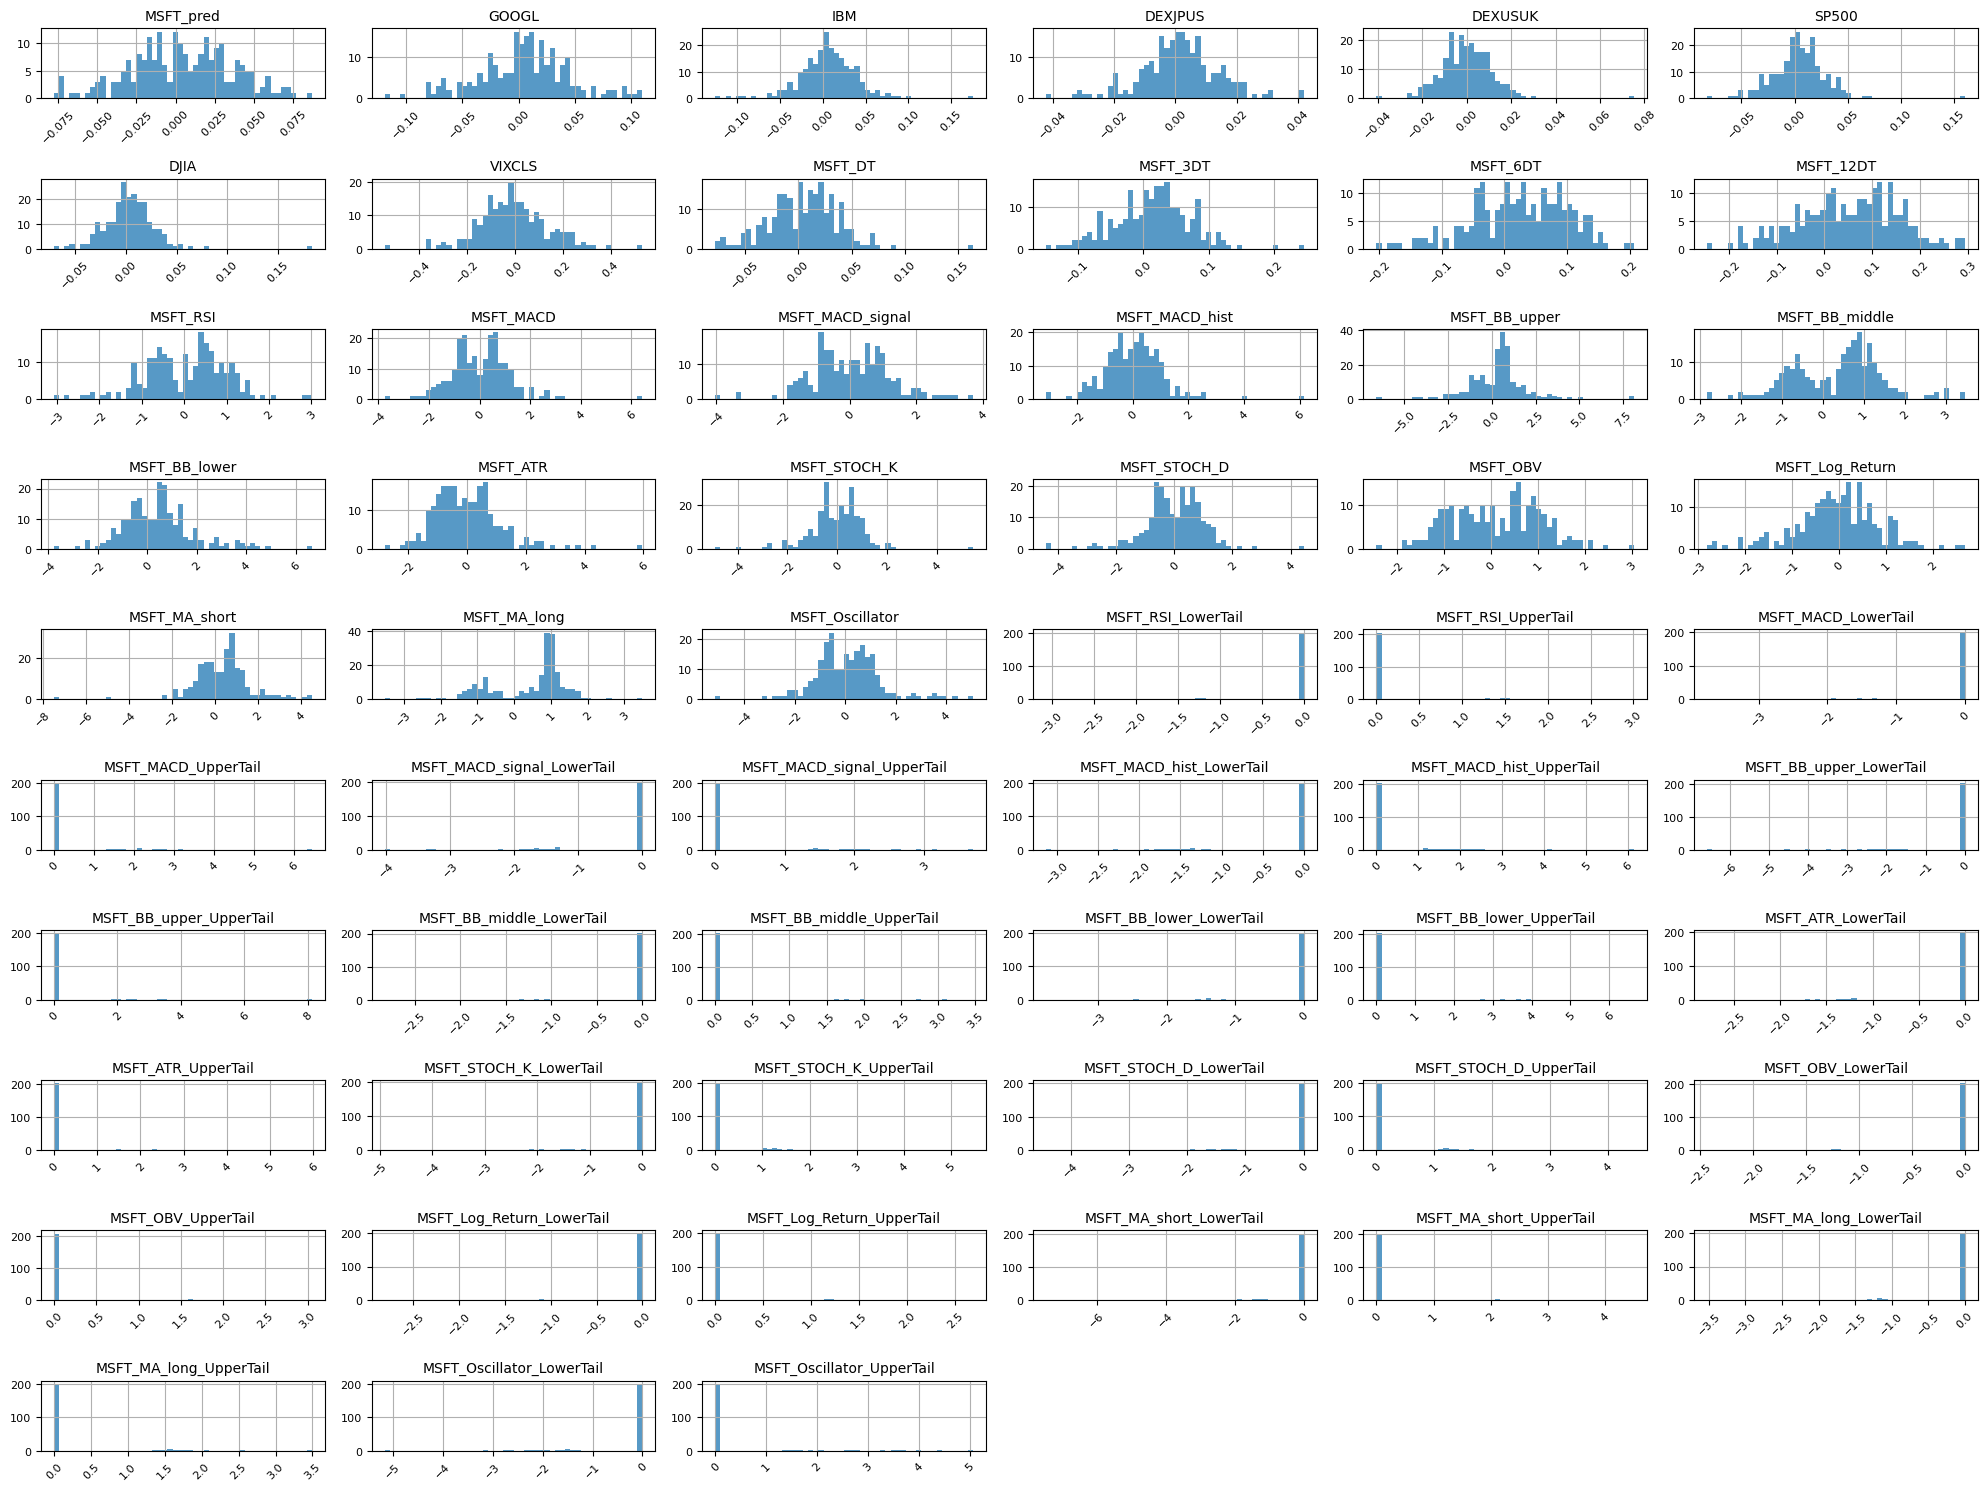

In [15]:
# Number of columns in the dataset
num_columns = dataset.shape[1]

# Calculate grid size
ncols = 6  # Number of columns in the grid
nrows = (num_columns + ncols - 1) // ncols  # Calculate the required number of rows

# Create the figure and axes
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 15))  # Adjust figure size
axes = axes.flatten()  # Flatten axes for easy iteration

# Plot each column as a histogram
for i, column in enumerate(dataset.columns):
    ax = axes[i]
    dataset[column].hist(bins=50, ax=ax, alpha=0.75)
    ax.set_title(column, fontsize=10)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

# Hide extra axes (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlaps
plt.tight_layout()
plt.show()


The above histogram shows the distribution for each series individually. Next, lets look at the density distribution over the same x axis scale.

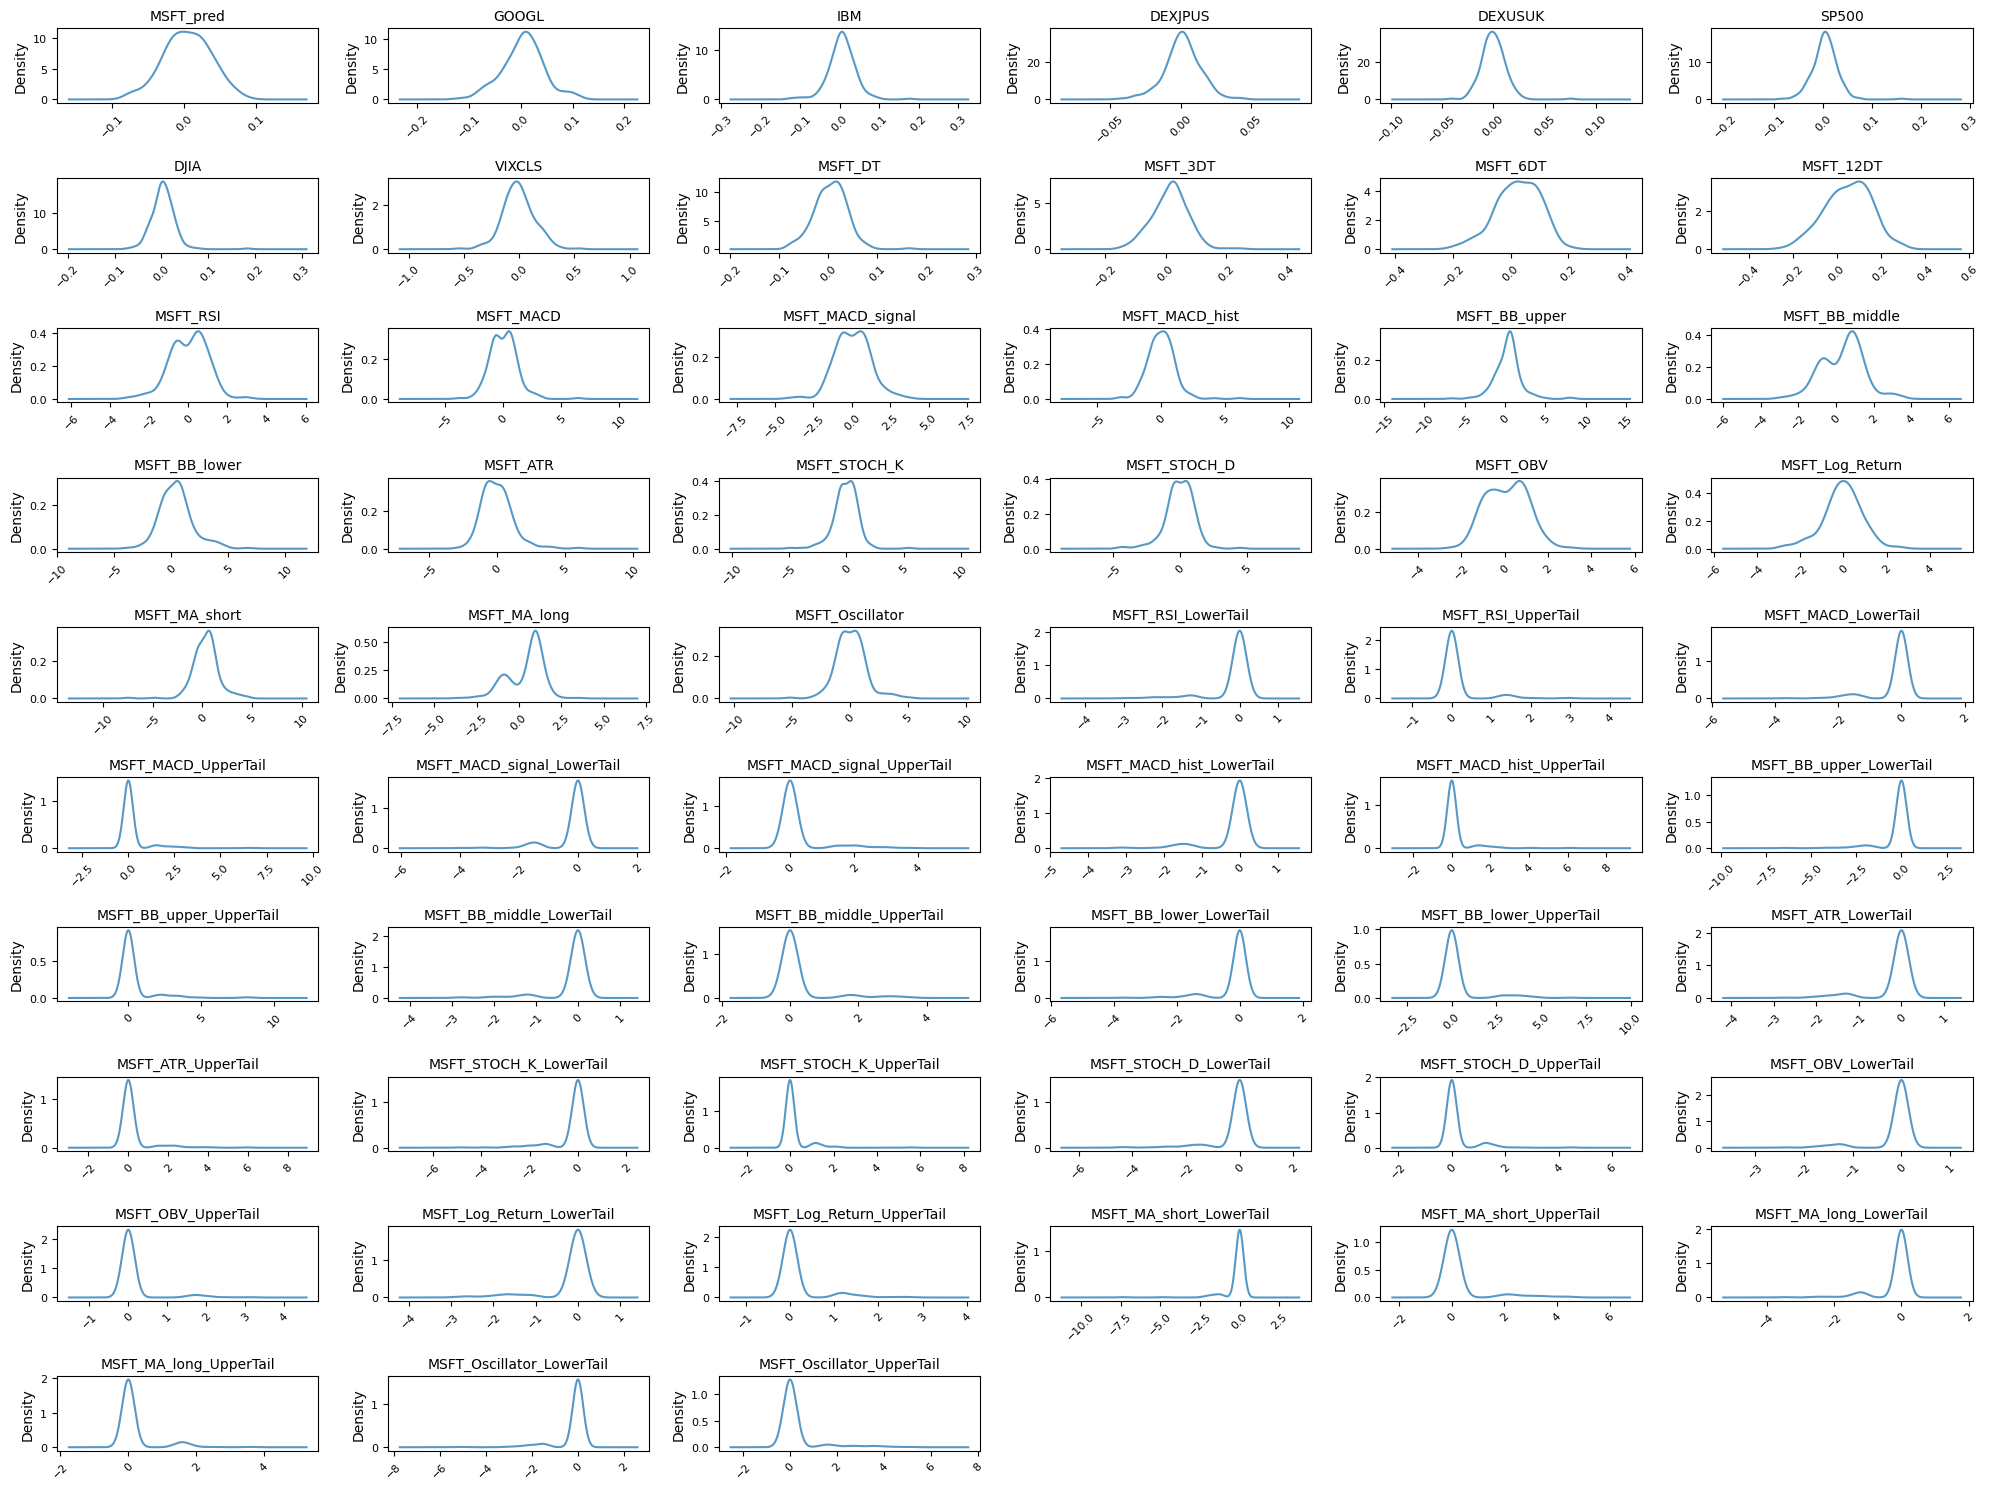

In [16]:
# Number of columns in the dataset
num_columns = dataset.shape[1]

# Calculate grid size
ncols = 6  # Number of columns per row
nrows = (num_columns + ncols - 1) // ncols  # Calculate the number of rows

# Create the figure and axes
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 15))  # Adjust figure size for density plots
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Plot density for each column
for i, column in enumerate(dataset.columns):
    ax = axes[i]
    dataset[column].plot(kind='density', ax=ax, alpha=0.75)
    ax.set_title(column, fontsize=10)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

# Hide unused subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


* We can tell that due to IQR Stabilization, the features are more stabilized (By centering them around their rolling mean and scaling them by the  IQR). This transformation reduces the effect of outliers and skes, making the distributions more uniform.   

In order to get a sense of the interdependence of the data we look at the scatter plot and the correlation matrix

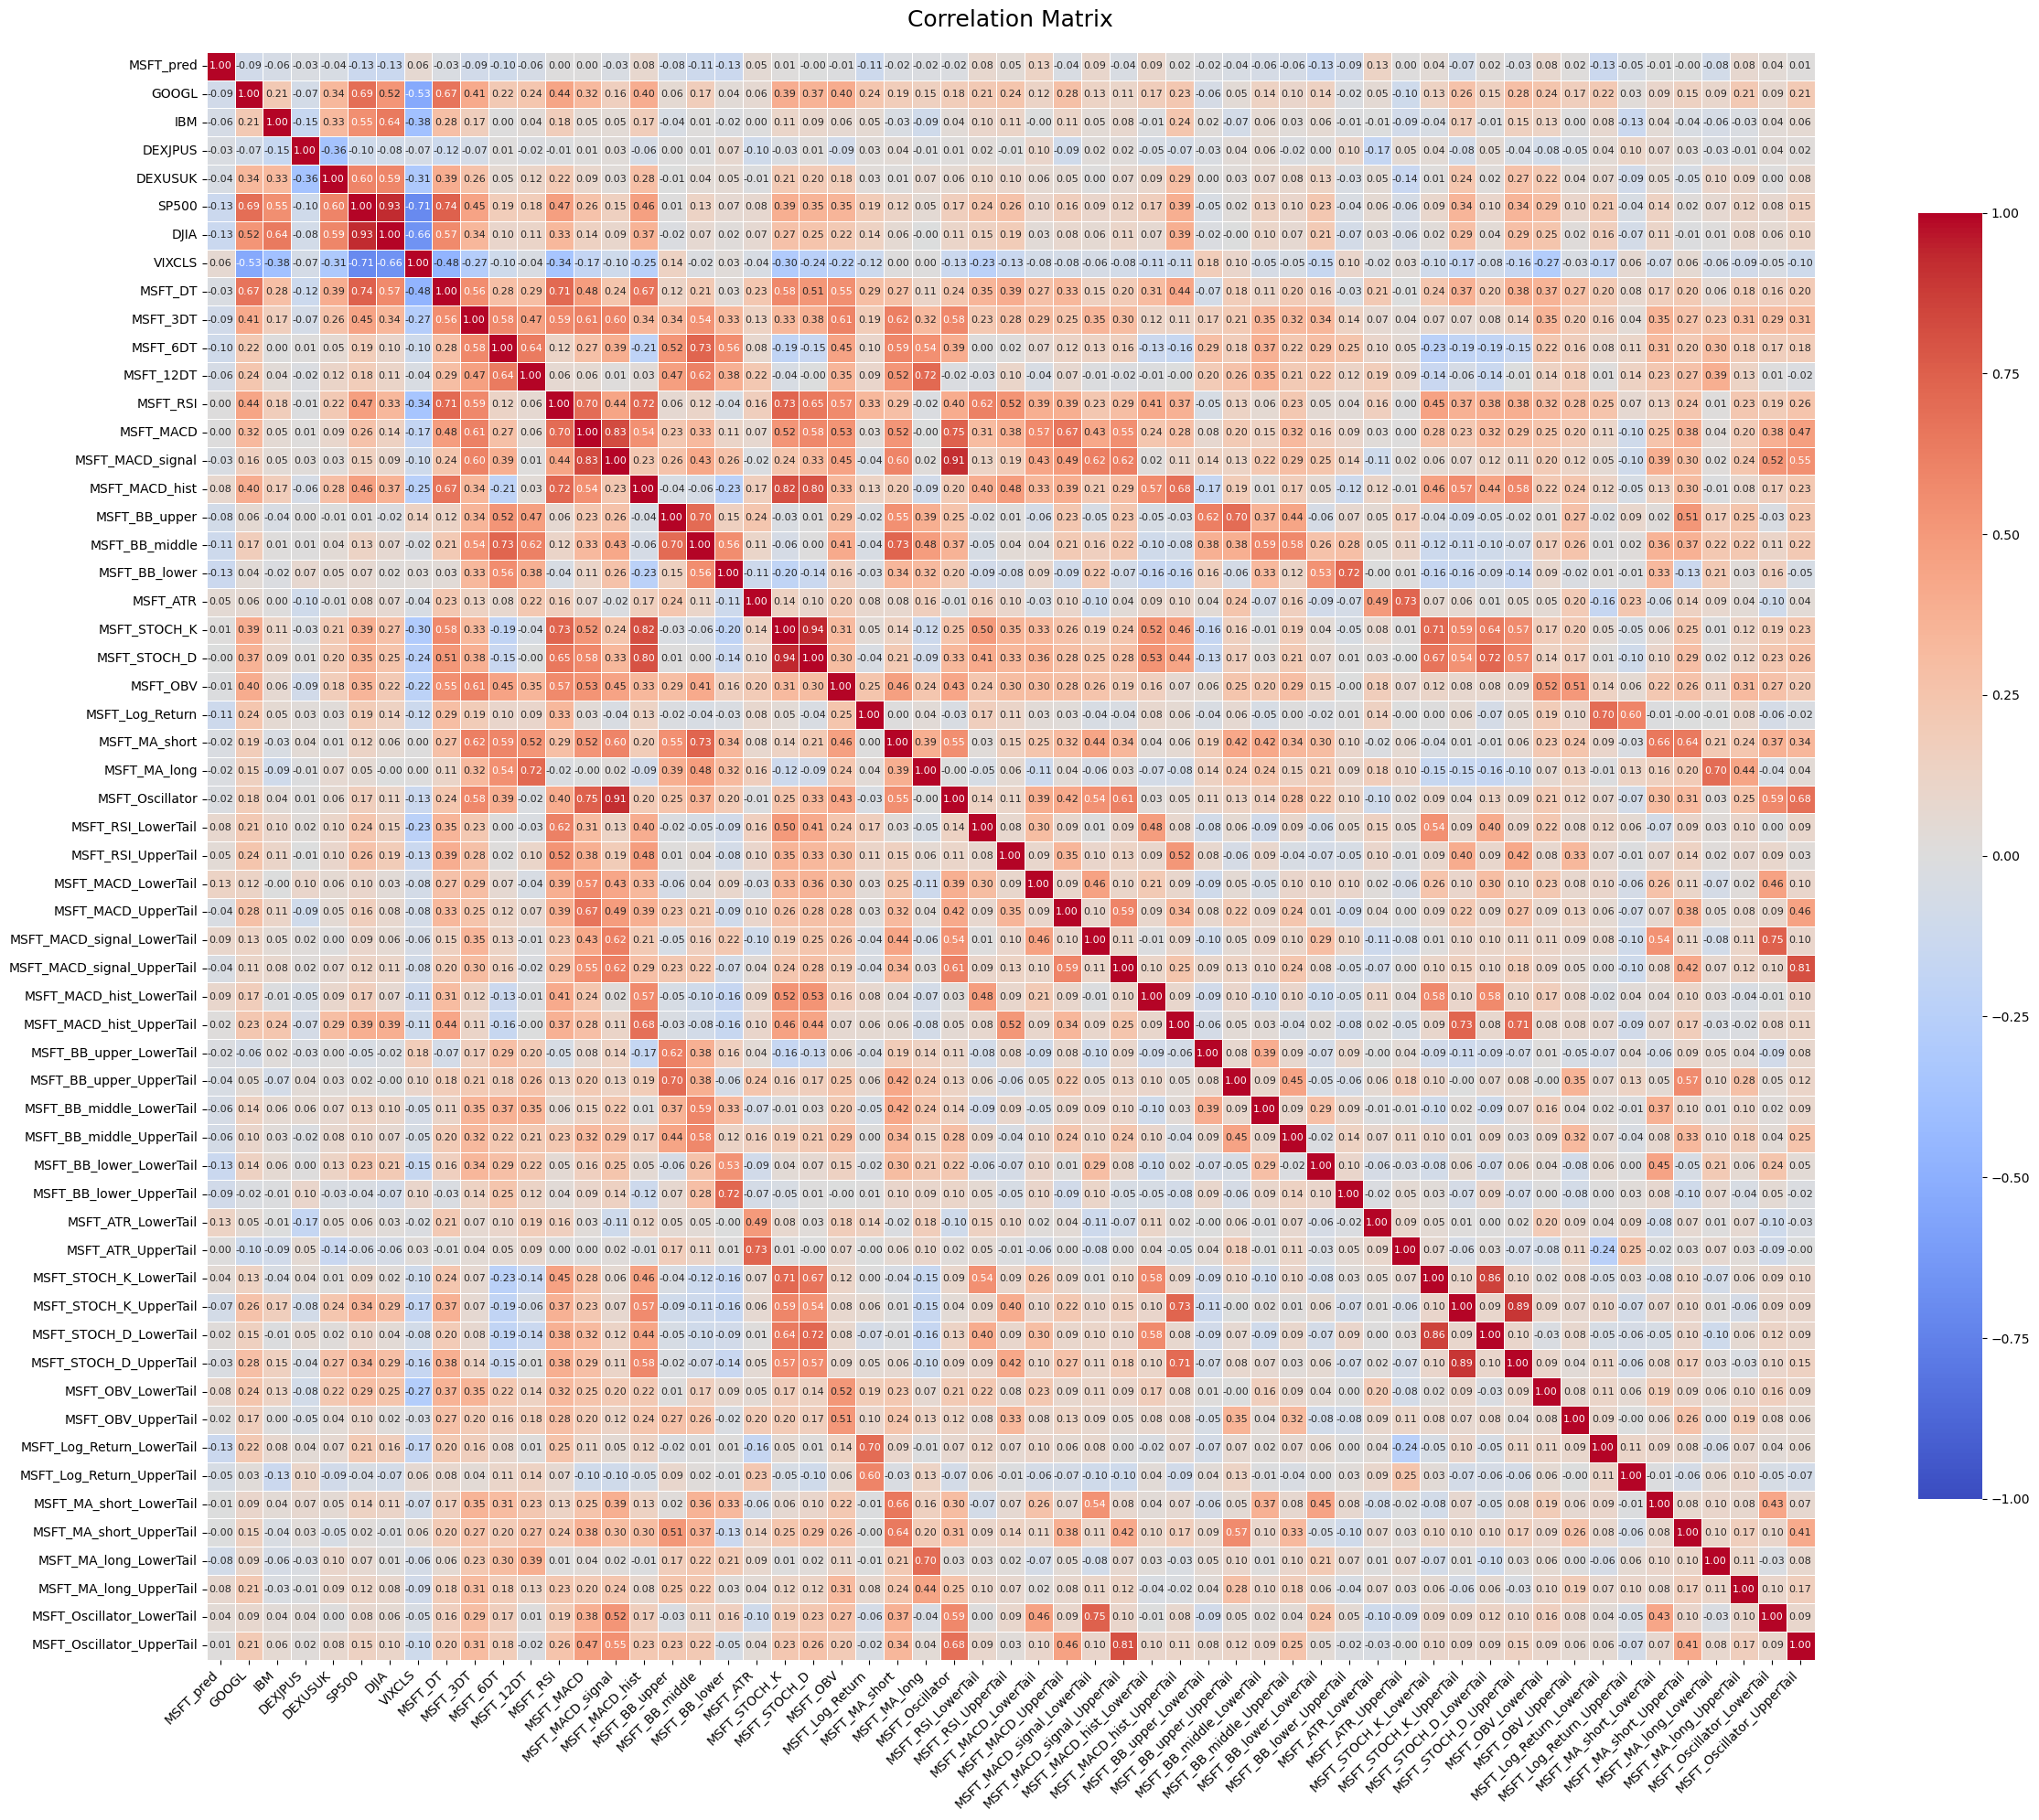

In [17]:
# Compute the correlation matrix
correlation = dataset.corr()

# Set up the matplotlib figure
plt.figure(figsize=(25, 20))  # Increase figure size for better readability

# Draw the heatmap with customizations
sns.heatmap(
    correlation,
    annot=True,  # Annotate with correlation coefficients
    fmt=".2f",  # Format annotations to 2 decimal places
    cmap="coolwarm",  # Use a visually clear colormap
    vmax=1, vmin=-1,  # Set color scale limits
    square=True,  # Make each cell square
    linewidths=0.5,  # Add space between cells
    annot_kws={"size": 8},  # Adjust annotation font size
    cbar_kws={"shrink": 0.8},  # Adjust colorbar size
)

# Customize the title and axis labels
plt.title("Correlation Matrix", fontsize=18, pad=20)
plt.xticks(fontsize=10, rotation=45, ha="right")  # Rotate x-axis labels
plt.yticks(fontsize=10, rotation=0)  # Rotate y-axis labels

# Display the heatmap
plt.tight_layout()
plt.show()


Looking at the correlation plot above, we see some correlation of the predicted vari‐
able with the lagged 5 days, 15days, 30 days and 60 days return of MSFT.

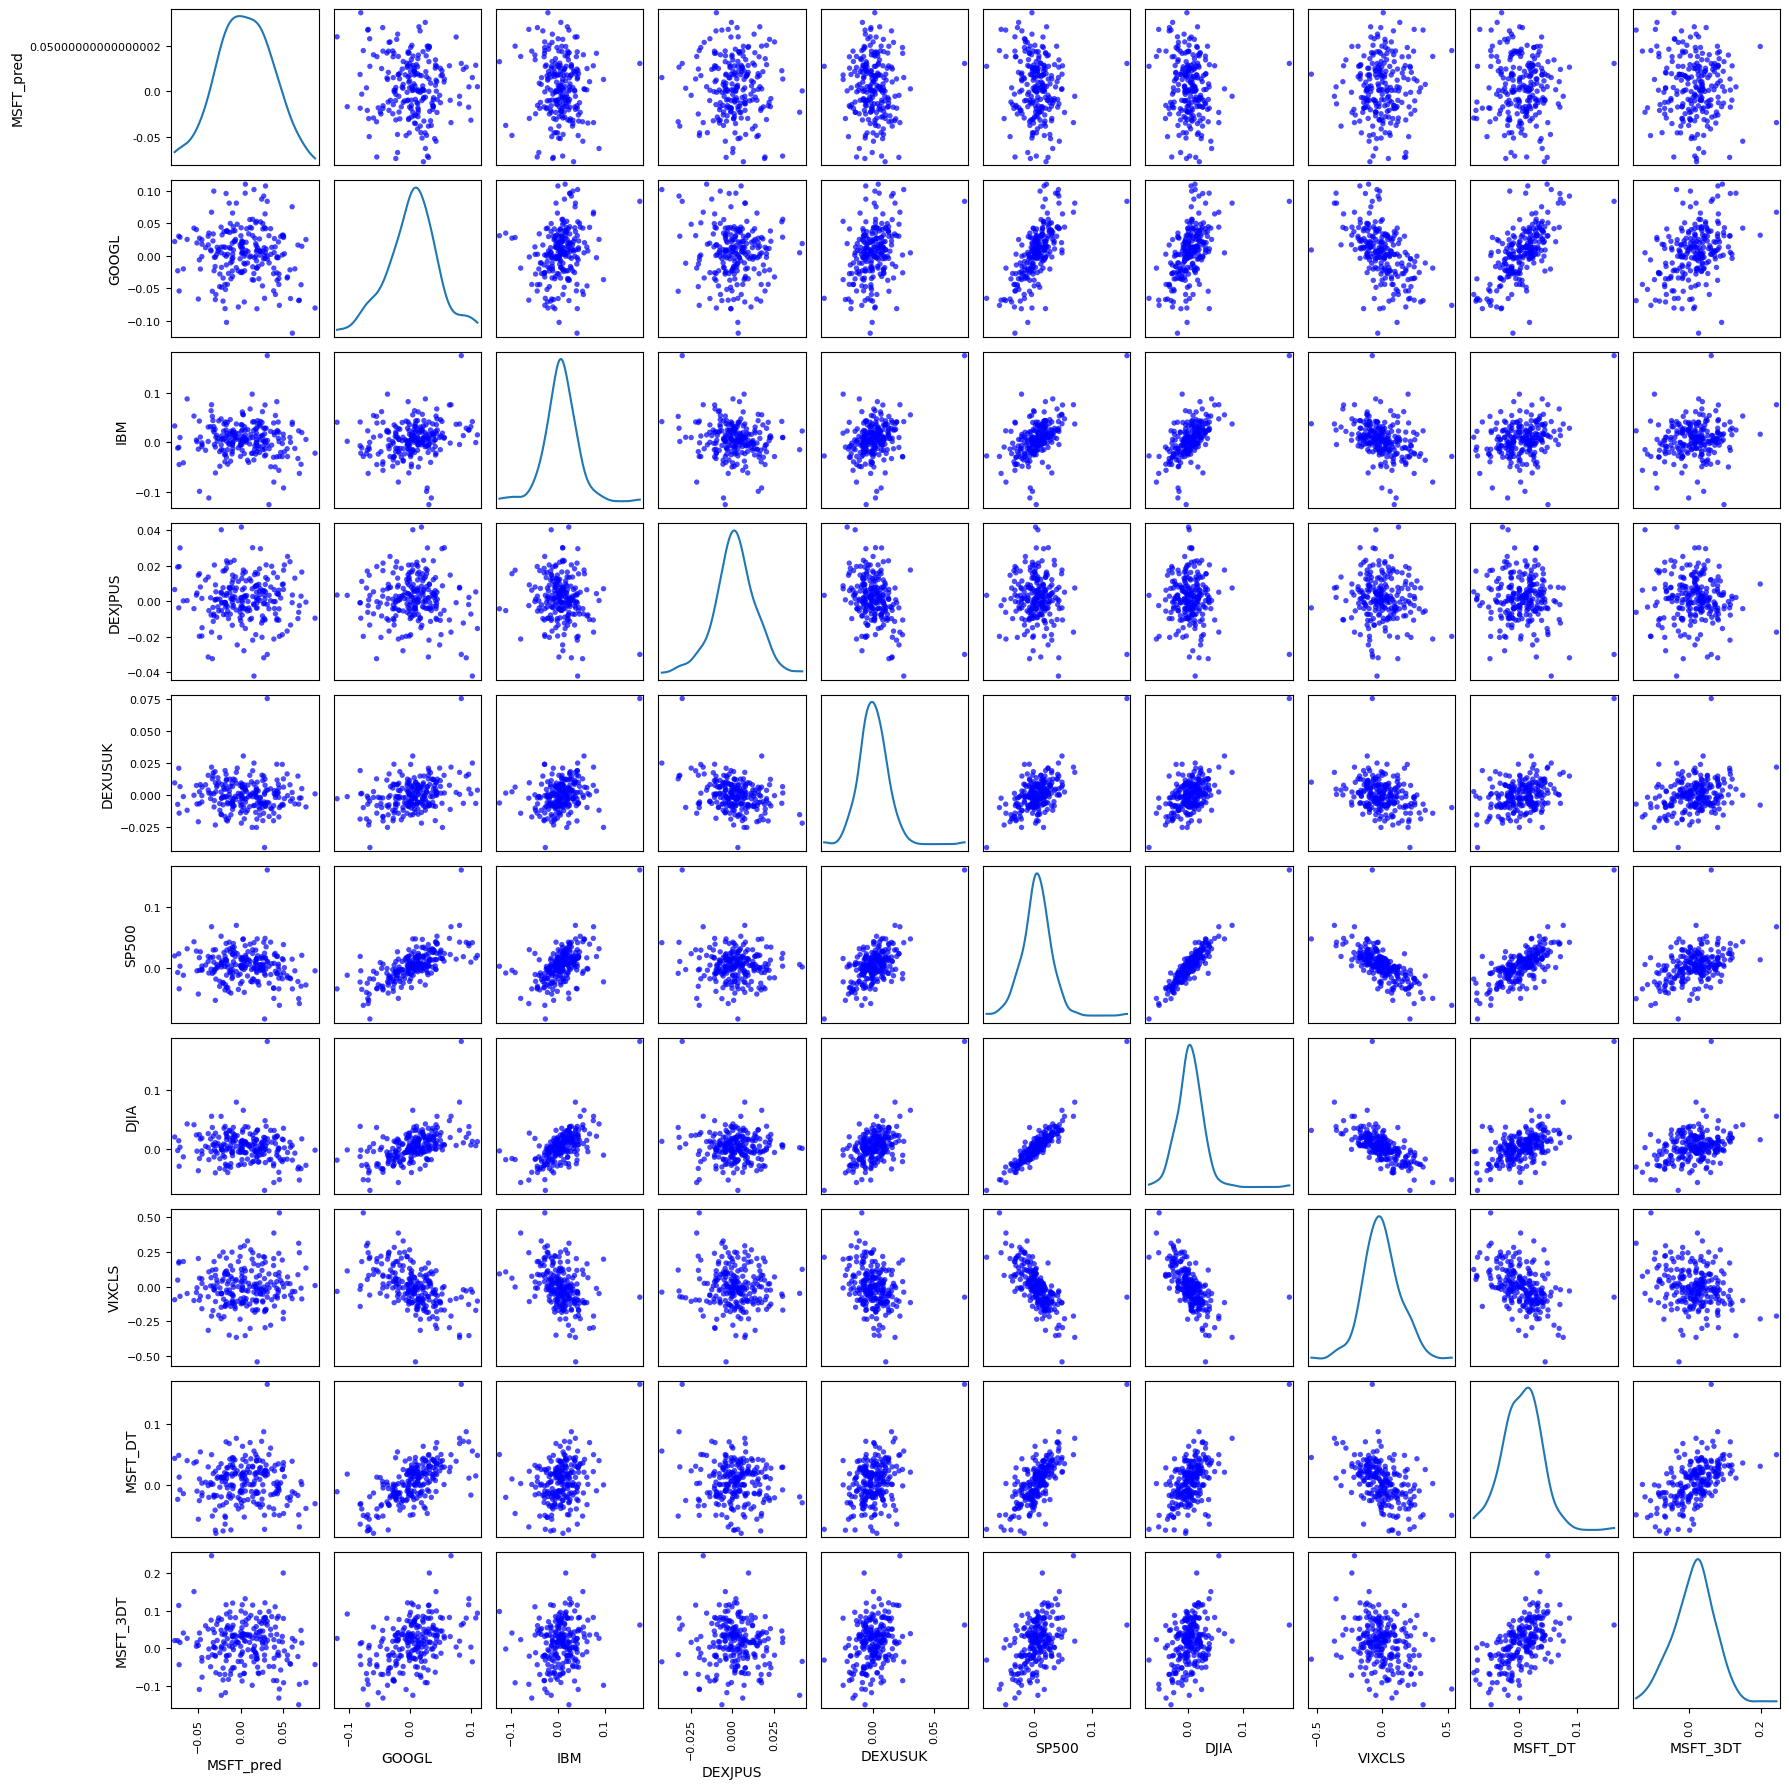

In [18]:
# Select a subset of columns (optional)
selected_columns = dataset.columns[:10]  # For example, select the first 10 columns
data_to_plot = dataset[selected_columns]

# Create the scatter matrix
scatter_matrix(
    data_to_plot,
    figsize=(18, 18),  # Increase figure size for better readability
    diagonal='kde',  # Use Kernel Density Estimation (KDE) for histograms on the diagonal
    marker='o',  # Use circles for scatter plots
    s=15,  # Marker size
    alpha=0.7,  # Marker transparency
    color='blue',  # Marker color
    hist_kwds={'bins': 20, 'color': 'lightblue'},  # Customize histogram appearance
    grid=True,  # Add gridlines for better separation
)

# Improve layout
plt.tight_layout()
plt.show()


Looking at the scatter plot above, we see some linear relationship of the predicted
variable the lagged 15 days, 30 days and 60 days return of MSFT.

<a id='2.3'></a>
## 3.3. Time Series Analysis

Next, we look at the seasonal decomposition of our time series

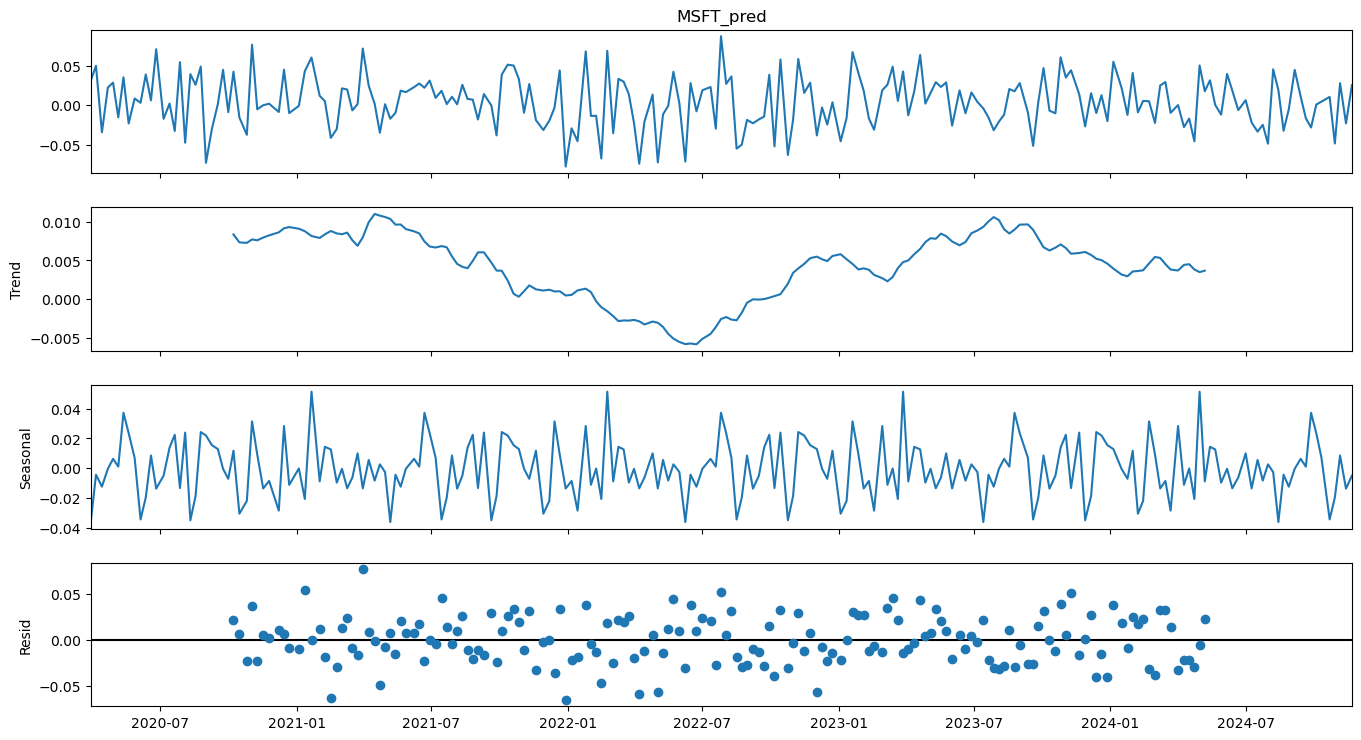

In [19]:
res = sm.tsa.seasonal_decompose(Y,period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

Instead, the decomposition highlights periodic seasonality and residual randomness, which can be modeled or accounted for in predictive models. Further statistical tests (e.g., Augmented Dickey-Fuller) can confirm the stationarity of the series.

<a id='3'></a>
## 4. Data Preparation

<a id='3.2'></a>
## 4.2. Feature Selection - Select Technical Features

In this section, we will be continue using the indicators that are used in the seed code. The feature selection method is applied to all the technical indicators to select the top informative feawtures.

There are 4 methods used in this section:
* mutual_info_regression
* f_regression
* PCA
* random_forest_importance

In [20]:
# Set the global seed 
seed = 7
np.random.seed(7)

##### Method 1: Using Mutual_info_regression to perform feature selection

In [21]:
# Test to use which percentile scorer
scorer = lambda X, y: mutual_info_regression(X, y, random_state=202)
selector = SelectPercentile(mutual_info_regression, percentile=10)

features_kbest = selector.fit_transform(X[features.columns], Y)

print(f"Original number of features: {features.shape[1]}")
print(f"New number of features: {features_kbest.shape[1]}")

Original number of features: 45
New number of features: 5


In [22]:
arr = np.transpose(selector.get_support())
selected_technical_features = features.columns[arr]
# Select the features that are not selected
unselect_technical_features = features.columns[np.where(selector.get_support() == False)
]
print("Index of best features: ", np.asarray(arr == True).nonzero())
print("Best features: ", selected_technical_features)

# Drop the unselect features using the master dataset (dataset)
dataset_filtered = dataset.drop(columns=unselect_technical_features)
X_mutual_info_regression = dataset_filtered.loc[:, dataset_filtered.columns != Y.name]
Y_mutual_info_regression = dataset_filtered.loc[:, dataset_filtered.columns == Y.name]

Index of best features:  (array([ 0,  3,  5, 15, 23]),)
Best features:  Index(['MSFT_RSI', 'MSFT_MACD_hist', 'MSFT_BB_middle', 'MSFT_RSI_LowerTail',
       'MSFT_BB_upper_LowerTail'],
      dtype='object')


##### Method 2: Use f_regression to perform feature selection

In [23]:
# Test to use which percentile scorer
selector = SelectPercentile(f_regression, percentile=10)
# selector = SelectPercentile(mutual_info_regression, percentile=10)

features_kbest = selector.fit_transform(X[features.columns], Y)

print(f"Original number of features: {features.shape[1]}")
print(f"New number of features: {features_kbest.shape[1]}")

Original number of features: 45
New number of features: 5


In [24]:
arr = np.transpose(selector.get_support())
selected_technical_features = features.columns[arr]
# Select the features that are not selected
unselect_technical_features = features.columns[np.where(selector.get_support() == False)
]
print("Index of best features: ", np.asarray(arr == True).nonzero())
print("Best features: ", selected_technical_features)

# Drop the unselect features using the master dataset (dataset)
dataset_filtered = dataset.drop(columns=unselect_technical_features)
X_f_regression = dataset_filtered.loc[:, dataset_filtered.columns != Y.name]
Y_f_regression = dataset_filtered.loc[:, dataset_filtered.columns == Y.name]

Index of best features:  (array([ 6, 17, 27, 29, 37]),)
Best features:  Index(['MSFT_BB_lower', 'MSFT_MACD_LowerTail', 'MSFT_BB_lower_LowerTail',
       'MSFT_ATR_LowerTail', 'MSFT_Log_Return_LowerTail'],
      dtype='object')


#### Method 3: Use PCA to find the important features

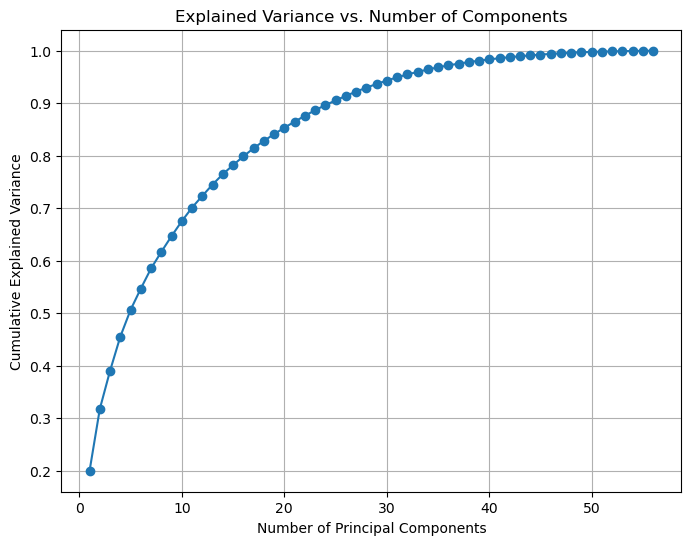

In [25]:
# Assuming X is your input features dataframe
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit PCA without specifying n_components to get all components
pca_full = PCA()
pca_full.fit(X_scaled)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()



 The actual implementation of using PCA is integreated in the pipeline (Shown in section 5)

#### Method 4: Use Random Forest to identify the Feature Importance

In [26]:
model = RandomForestRegressor(random_state=seed)
model.fit(X[features.columns], Y)

# Feature importance
feature_importances = pd.DataFrame({'feature': features.columns,
                                    'importance': model.feature_importances_})
feature_importances.sort_values(by='importance', ascending=False, inplace=True)
print(feature_importances)


                       feature  importance
12               MSFT_MA_short       0.073
7                     MSFT_ATR       0.070
5               MSFT_BB_middle       0.068
11             MSFT_Log_Return       0.063
6                MSFT_BB_lower       0.062
4                MSFT_BB_upper       0.061
13                MSFT_MA_long       0.058
10                    MSFT_OBV       0.056
1                    MSFT_MACD       0.054
0                     MSFT_RSI       0.053
2             MSFT_MACD_signal       0.051
14             MSFT_Oscillator       0.051
9                 MSFT_STOCH_D       0.045
3               MSFT_MACD_hist       0.043
8                 MSFT_STOCH_K       0.029
29          MSFT_ATR_LowerTail       0.021
24     MSFT_BB_upper_UpperTail       0.014
37   MSFT_Log_Return_LowerTail       0.014
19  MSFT_MACD_signal_LowerTail       0.013
43   MSFT_Oscillator_LowerTail       0.010
22    MSFT_MACD_hist_UpperTail       0.009
25    MSFT_BB_middle_LowerTail       0.006
27     MSFT

In [27]:
# Select the top 5 features accordingly
top_features = feature_importances['feature'].head(5).tolist()
unselect_techincal_features = feature_importances['feature'].iloc[5:].tolist()
print("Top Selected Features:", top_features)
print("Unselected Features:", unselect_techincal_features)

# Drop the unselect features using the master dataset (dataset)
dataset_filtered = dataset.drop(columns=unselect_technical_features)
X_rf_importance = dataset_filtered.loc[:, dataset_filtered.columns != Y.name]
Y_rf_importance = dataset_filtered.loc[:, dataset_filtered.columns == Y.name]

Top Selected Features: ['MSFT_MA_short', 'MSFT_ATR', 'MSFT_BB_middle', 'MSFT_Log_Return', 'MSFT_BB_lower']
Unselected Features: ['MSFT_BB_upper', 'MSFT_MA_long', 'MSFT_OBV', 'MSFT_MACD', 'MSFT_RSI', 'MSFT_MACD_signal', 'MSFT_Oscillator', 'MSFT_STOCH_D', 'MSFT_MACD_hist', 'MSFT_STOCH_K', 'MSFT_ATR_LowerTail', 'MSFT_BB_upper_UpperTail', 'MSFT_Log_Return_LowerTail', 'MSFT_MACD_signal_LowerTail', 'MSFT_Oscillator_LowerTail', 'MSFT_MACD_hist_UpperTail', 'MSFT_BB_middle_LowerTail', 'MSFT_BB_lower_LowerTail', 'MSFT_STOCH_D_UpperTail', 'MSFT_MA_long_LowerTail', 'MSFT_BB_lower_UpperTail', 'MSFT_BB_upper_LowerTail', 'MSFT_BB_middle_UpperTail', 'MSFT_RSI_UpperTail', 'MSFT_RSI_LowerTail', 'MSFT_MACD_hist_LowerTail', 'MSFT_STOCH_D_LowerTail', 'MSFT_MACD_LowerTail', 'MSFT_ATR_UpperTail', 'MSFT_Oscillator_UpperTail', 'MSFT_OBV_LowerTail', 'MSFT_STOCH_K_UpperTail', 'MSFT_MA_short_LowerTail', 'MSFT_MA_long_UpperTail', 'MSFT_STOCH_K_LowerTail', 'MSFT_MACD_signal_UpperTail', 'MSFT_MACD_UpperTail', 'MSFT_

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split and Evaluation Metrics

Next, we start by splitting our data in training and testing chunks. If we are going to use Time series models we have to split the data in continous series.

In this helper function **train_test_split()**, we are able to prepare the training and testing chunks according to the applied feature selector method

In [28]:
# Make this a function for reproducibility
def train_test_split(feature_selector_method, test_size=0.2):

  validation_size = test_size

  feature_selector = ['f_regression', 'mutual_info_regression', 'pca', 'random_forest_importance']

  feature_selector_method = feature_selector_method.lower()

  x_y_data = [(X_f_regression, Y_f_regression), (X_mutual_info_regression, Y_mutual_info_regression), (X, Y), (X_rf_importance, Y_rf_importance)]

  X_filtered, Y_filtered = x_y_data[feature_selector.index(feature_selector_method)]


  train_size = int(len(X_filtered) * (1-validation_size))
  X_train, X_test = X_filtered[0:train_size], X_filtered[train_size:len(X)]
  Y_train, Y_test = Y_filtered[0:train_size], Y_filtered[train_size:len(X)]

  return X_train, X_test, Y_train, Y_test

<a id='4.2'></a>
## 5.2. Test Options and Evaluation Metrics

In [29]:
num_folds = 10
# scikit is moving away from mean_squared_error.
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error'

<a id='4.3'></a>
## 5.3. Compare Models and Algorithms

<a id='4.3.1'></a>
### 5.3.1 Machine Learning models-from scikit-learn

In [30]:
# Set random seed for reproducibility

models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso(random_state=seed)))
models.append(('EN', ElasticNet(random_state=seed)))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor(random_state=seed)))
models.append(('SVR', SVR()))
models.append(('MLP', MLPRegressor(random_state=seed)))
# Boosting methods
models.append(('ABR', AdaBoostRegressor(random_state=seed)))
models.append(('GBR', GradientBoostingRegressor(random_state=seed)))
# Bagging methods
models.append(('RFR', RandomForestRegressor(random_state=seed)))
models.append(('ETR', ExtraTreesRegressor(random_state=seed)))

Once we have selected all the models, we loop over each of them. 

The loop includes:
* Iterating through all feature methods
* Iterate through all models

Then we find the most robust model by evaluating
* Testing Error
* Gap between train and test errors (Prevent Overfitting)

In [31]:
feature_selector = ['f_regression', 'mutual_info_regression', 'pca', 'random_forest_importance']

lowest_test_results = {}
kfold_results = {}
train_results = {}
test_results = {}

for feature_selector_method in feature_selector:
  print("\n" + feature_selector_method)
  X_train, X_test, Y_train, Y_test = train_test_split(feature_selector_method)

  names = []
  feature_selector_kfold_results = {}
  feature_selector_test_results = {}
  feature_selector_train_results = {}

  for name, model in models:

      names.append(name)

      if feature_selector_method == 'pca':
        pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.85, random_state=seed)),
        ('model', model)
        ])
        model = pipeline

      # kfold = KFold(n_splits=num_folds, random_state=seed)
      kfold = KFold(n_splits=num_folds, shuffle=False)
      #converted mean square error to positive. The lower the beter
      cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
      feature_selector_kfold_results[name] = (cv_results)


      # Full Training period
      res = model.fit(X_train, Y_train)
      train_result = mean_squared_error(res.predict(X_train), Y_train)

      feature_selector_train_results[name] = train_result

      # Test results
      test_result = mean_squared_error(res.predict(X_test), Y_test)
      feature_selector_test_results[name] = test_result

      msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
      print(msg)

  # After finish all the models store the result
  kfold_results[feature_selector_method] = feature_selector_kfold_results
  train_results[feature_selector_method] = feature_selector_train_results
  test_results[feature_selector_method] = feature_selector_test_results

  print(f"Lowest Test Results: {names[np.argmin(np.array(list(feature_selector_test_results.values())))]}, {np.min(np.array(list(feature_selector_test_results.values())))}")
  lowest_test_results[feature_selector_method] = (
     # Model name
     names[np.argmin(np.array(list(feature_selector_test_results.values())))],
     # Training Error
     train_results[feature_selector_method][names[np.argmin(np.array(list(feature_selector_test_results.values())))]], 
     # Testing Error
     np.min(np.array(list(feature_selector_test_results.values()))))

# # Find the lowest test results
# selector = list(lowest_test_results.keys())[np.argmin(np.array([i[1] for i in lowest_test_results.values()]))]
# print(f"\nLowest Test Results: ({selector}, {lowest_test_results[selector]})")


f_regression
LR: 0.001277 (0.000473) 0.001041 0.000638
LASSO: 0.001126 (0.000497) 0.001126 0.000738
EN: 0.001126 (0.000497) 0.001126 0.000738


  File "c:\Users\User\anaconda3\envs\APS1052_Final\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


KNN: 0.001408 (0.000617) 0.000935 0.000880
CART: 0.002208 (0.000962) 0.000000 0.002294
SVR: 0.001121 (0.000491) 0.001127 0.000736
MLP: 0.004008 (0.002346) 0.002357 0.002482
ABR: 0.001360 (0.000633) 0.000604 0.000937
GBR: 0.001513 (0.000701) 0.000110 0.001084
RFR: 0.001285 (0.000556) 0.000173 0.000797
ETR: 0.001295 (0.000597) 0.000000 0.000847
Lowest Test Results: LR, 0.0006375943937565235

mutual_info_regression
LR: 0.001250 (0.000454) 0.001053 0.000693
LASSO: 0.001126 (0.000497) 0.001126 0.000738
EN: 0.001126 (0.000497) 0.001126 0.000738
KNN: 0.001408 (0.000541) 0.000985 0.000695
CART: 0.002820 (0.001028) 0.000000 0.001399
SVR: 0.001121 (0.000491) 0.001127 0.000736
MLP: 0.003345 (0.002330) 0.002250 0.003324
ABR: 0.001333 (0.000599) 0.000536 0.000835
GBR: 0.001625 (0.000715) 0.000097 0.001071
RFR: 0.001295 (0.000603) 0.000169 0.000818
ETR: 0.001286 (0.000615) 0.000000 0.000697
Lowest Test Results: LR, 0.0006932589371241327

pca
LR: 0.001249 (0.000499) 0.001007 0.000675
LASSO: 0.001126 

In [32]:
# Find the best model accounting the testing error and overfitting
def overfitting_ratio(training_error, testing_error):
    return np.abs((training_error-testing_error))/training_error

def balance_testerror_overfitting(w1=0.8, w2=0.2, test_error=None, overfit_ratio=None):
    penalty = overfit_ratio
    model_score = w1*test_error-w2*penalty
    return model_score

best_model_score = -np.inf
best_balance_model = [0,0]
for (selector, model) in lowest_test_results.items():
    model_name, model_train_error, model_test_error = model
    overfit_ratio = overfitting_ratio(model_train_error, model_test_error)
    model_score = balance_testerror_overfitting(test_error = model_test_error, overfit_ratio=overfit_ratio)
    if model_score>best_model_score:
        best_model_score = model_score
        best_balance_model[0], best_balance_model[1] = selector, model_name

print(f"The best balanced model: {best_balance_model}")


The best balanced model: ['mutual_info_regression', 'LR']


The best model can be concluded as using feature selection **"PCA"** and model **"ABR"**

#### K Fold results

We being by looking at the K Fold results when using **PCA** as feature selector

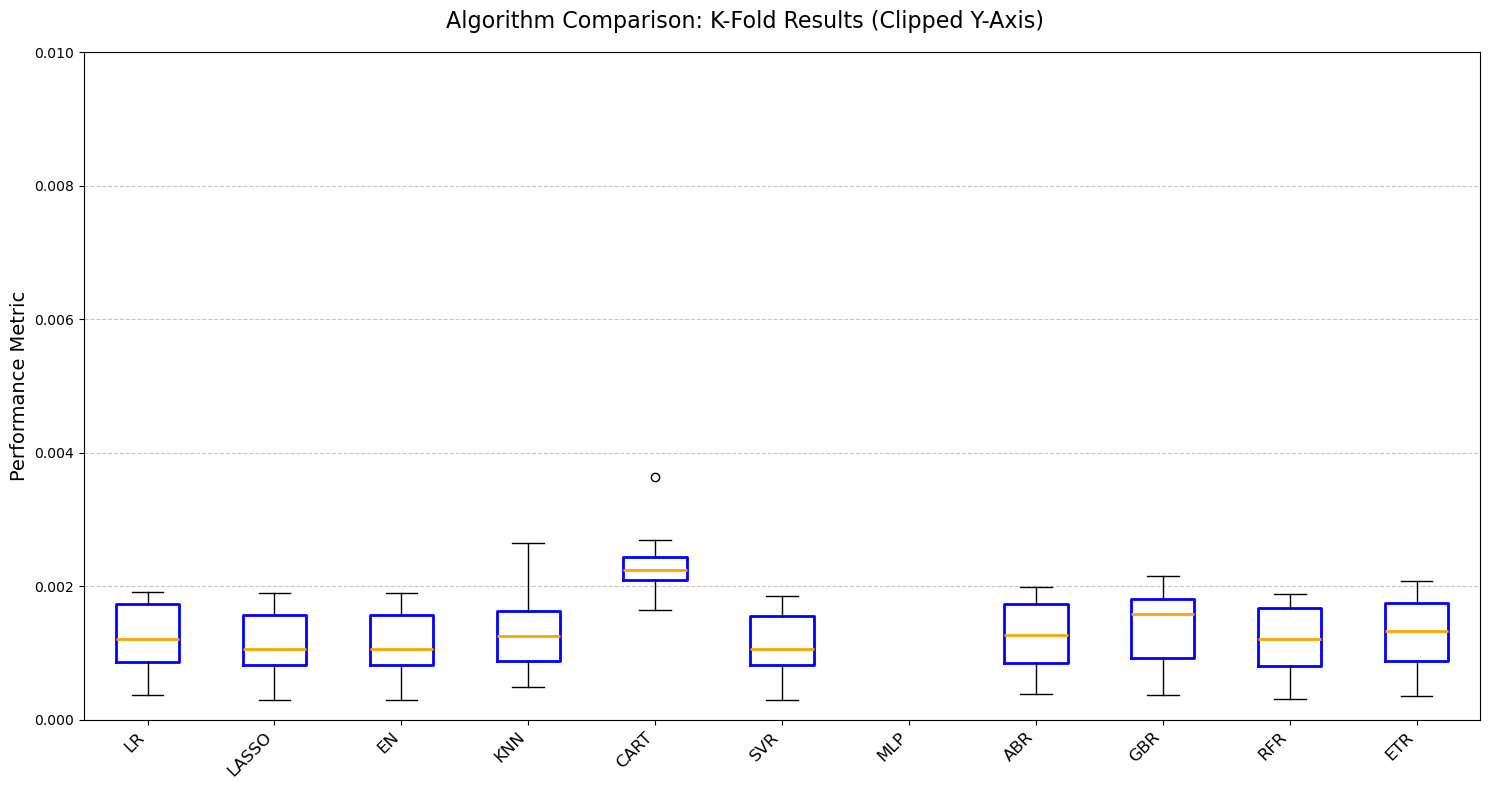

In [33]:
# Clip the y-axis
fig = plt.figure(figsize=(15, 8))
fig.suptitle('Algorithm Comparison: K-Fold Results (Clipped Y-Axis)', fontsize=16)
ax = fig.add_subplot(111)
ax.boxplot(kfold_results['pca'].values(), boxprops=dict(color='blue', linewidth=2), medianprops=dict(color='orange', linewidth=2))

# Set y-axis limits
ax.set_ylim([0, 0.01])  # Adjust the range to focus on smaller values
ax.set_xticklabels(names, fontsize=12, rotation=45, ha='right')
ax.set_ylabel('Performance Metric', fontsize=14)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


The graph is cilp at error of 0.01 since we are only interested in models that has relatively lower error.

From the graph we can conclude that besides **"MLP"**, all other models perform relatively well

#### Training and Test error

We can tell that using PCA as feature selector and using Machine Learning model **"ABR"** gives the best result. Therefore, we will plot the training and testing error using **PCA** as feature selector and compare with all other machine learning models

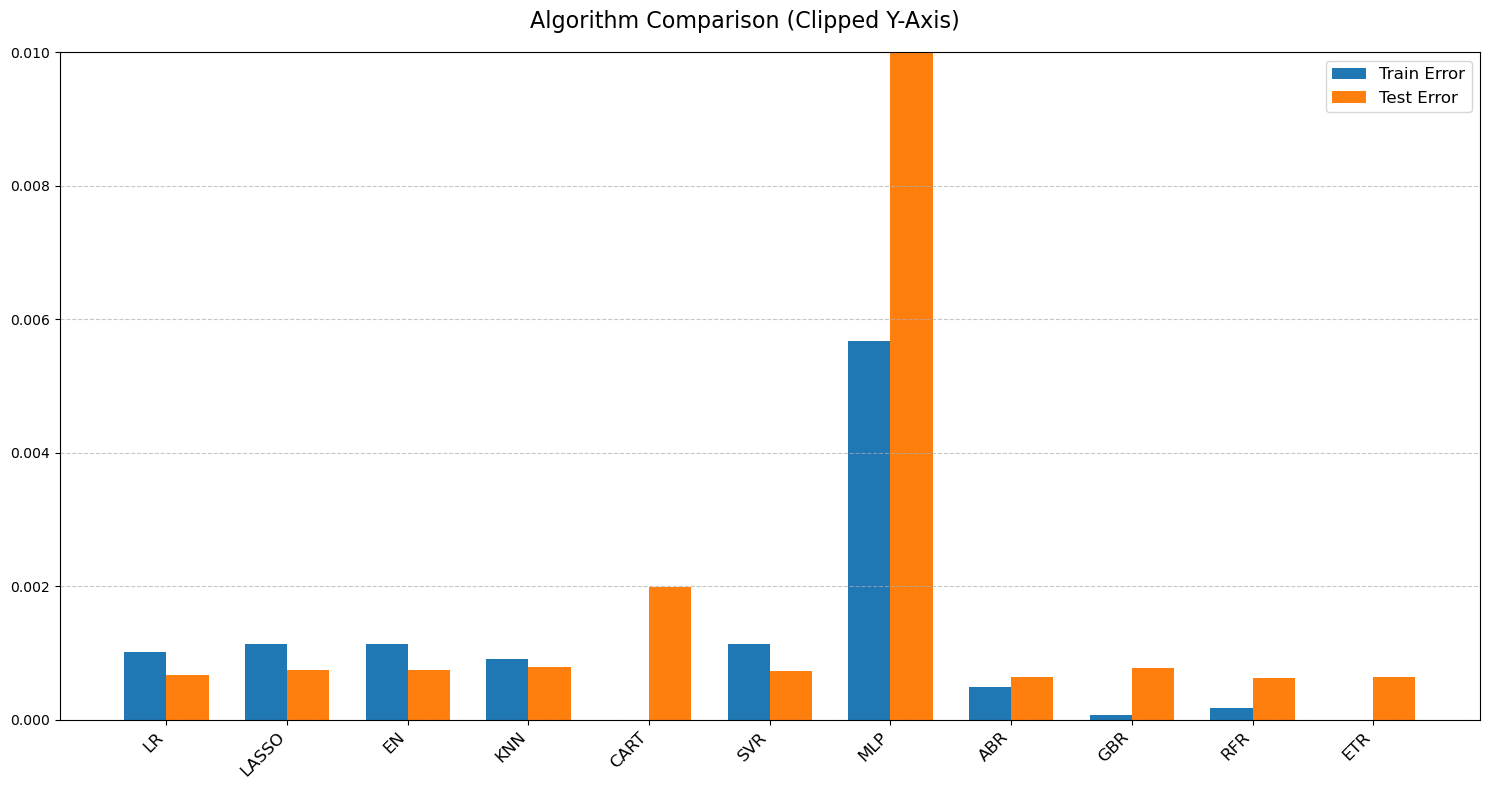

In [34]:
# Set up x locations and bar width
ind = np.arange(len(names))  # x locations
width = 0.35  # width of bars

# Create the plot
fig = plt.figure(figsize=(15, 8))
fig.suptitle('Algorithm Comparison (Clipped Y-Axis)', fontsize=16)

ax = fig.add_subplot(111)

# Bar plots for train and test errors
ax.bar(ind - width / 2, train_results['pca'].values(), width=width, label='Train Error')
ax.bar(ind + width / 2, test_results['pca'].values(), width=width, label='Test Error')

# Set x-axis labels and legend
ax.set_xticks(ind)
ax.set_xticklabels(names, fontsize=12, rotation=45, ha='right')
ax.legend(fontsize=12)

# Clip the y-axis
ax.set_ylim([0, 0.01])  # Focus on smaller values, clipping MLP's large error

# Add grid lines
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Improve layout
plt.tight_layout()
plt.show()

The training error is also clipped at 0.01 due to the same reason that we are only interested in the models that have lower error

Looking at the training and test error, we still see a better performance of the linear models. Some of the algorithms, such as the decision tree regressor (CART) overfit on
the training data and produced very high error on the test set and these models
should be avoided. Ensemble models, such as gradient boosting regression (GBR) and
random forest regression (RFR) have low bias but high variance. We also see that the
artificial neural network (shown as MLP is the chart) algorithm shows higher errors
both in training set and test set, which is perhaps due to the linear relationship of the
variables not captured accurately by ANN or improper hyperparameters or insuffi‐
cient training of the model.

<a id='4.3.1'></a>
### 5.3.1 Time Series based models-ARIMA and LSTM

For ARIMA model we use auto arima to automatically search through the parameters. In the ARIMA model pipeline, we also prepare the dataset to only having the correlated variables as exogenous variables

### Time Series Model - ARIMA Model

In [35]:
error_Training_ARIMA = {}
error_Test_ARIMA = {}

feature_selector = ['f_regression', 'mutual_info_regression', 'pca', 'random_forest_importance']

for feature_selector_method in feature_selector:
  print("\n" + feature_selector_method)
  X_train, X_test, Y_train, Y_test = train_test_split(feature_selector_method)

  correlation_matrix = X_train.corrwith(Y_train)

  # Sort features by absolute correlation
  selected_features = correlation_matrix.sort_values(ascending=False)[:8]
  selected_features = selected_features.index.tolist()
  print("Top Selected Features:", selected_features)

  # Find the index with respect to the column
  selected_indices = [list(X_train.columns).index(feature) for feature in selected_features]
  selected_indices

  X_train_ARIMA=X_train.iloc[:, selected_indices]
  X_test_ARIMA=X_test.iloc[:, selected_indices]
  tr_len = len(X_train_ARIMA)
  te_len = len(X_test_ARIMA)
  to_len = len(X)

  # modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[1,0,0])
  # Use auto_arima to find the best parameters
  model_fit = auto_arima(
    Y_train,
    exogenous=X_train_ARIMA,
    start_p=0,
    start_q=0,
    max_p=5,          # Wider range for AR terms
    max_q=5,          # Wider range for MA terms
    seasonal=True,    # Enable seasonal components
    m=52,             # Seasonal period (e.g., monthly data)
    start_P=0,        # Start for seasonal AR terms
    start_Q=0,        # Start for seasonal MA terms
    max_P=3,          # Max seasonal AR terms
    max_Q=3,          # Max seasonal MA terms
    stepwise=True,    # Stepwise search
    trace=True,       # Display progress
    error_action="ignore",
    suppress_warnings=True,
    random_state=42
)

  # model_fit = modelARIMA.fit()
  # print(model_fit.summary())

  train_predictions = model_fit.predict_in_sample(start=0, end=len(Y_train) - 1)
  error_Training_ARIMA[feature_selector_method] = mean_squared_error(Y_train, train_predictions)
  predicted = model_fit.predict(X_test_ARIMA.shape[0])
  error_Test_ARIMA[feature_selector_method] = mean_squared_error(Y_test,predicted)
  print(f"ARIMA Train Error: {error_Training_ARIMA[feature_selector_method]}")
  print(f"ARIMA Test Error: {error_Test_ARIMA[feature_selector_method]}")


f_regression
Top Selected Features: ['DEXJPUS', 'DEXUSUK', 'DJIA', 'GOOGL', 'IBM', 'MSFT_12DT', 'MSFT_3DT', 'MSFT_6DT']
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=-695.286, Time=0.14 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=-691.705, Time=1.11 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=-691.695, Time=0.90 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=-693.327, Time=0.02 sec
 ARIMA(0,0,0)(1,0,0)[52] intercept   : AIC=-693.372, Time=1.05 sec
 ARIMA(0,0,0)(0,0,1)[52] intercept   : AIC=-693.380, Time=0.71 sec
 ARIMA(0,0,0)(1,0,1)[52] intercept   : AIC=-691.362, Time=0.67 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=-693.635, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=-693.619, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[52] intercept   : AIC=-691.626, Time=0.14 sec

Best model:  ARIMA(0,0,0)(0,0,0)[52] intercept
Total fit time: 4.944 seconds
ARIMA Train Error: 0.0011264949054473111
ARIMA Test Error: 0.0007381617908776561

mutual

In [36]:
min = np.inf
best_arima_selector = ""
for selector, test_error in error_Test_ARIMA.items():
    if test_error < min:
        min = test_error
        best_arima_selector = selector

print(f"Best ARIMA selector: {selector}\nTest Error: {min}")

Best ARIMA selector: random_forest_importance
Test Error: 0.0007381617908776561


###  LSTM Model

In [37]:
seq_len = 2 #Length of the seq for the LSTM

def generate_LSTM_data(feature_selector):
    X_train, X_test, Y_train, Y_test = train_test_split(feature_selector)

    total_X = pd.concat([X_train, X_test])

    Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len-1:], np.array(Y_test)
    X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len, seq_len, X_train.shape[1]))
    X_test_LSTM = np.zeros((X_test.shape[0], seq_len, total_X.shape[1]))
    for i in range(seq_len):
        X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
        X_test_LSTM[:, i, :] = np.array(total_X)[X_train.shape[0]+i-1:total_X.shape[0]+i+1-seq_len, :]

    return X_train_LSTM, X_test_LSTM, Y_train_LSTM, Y_test_LSTM


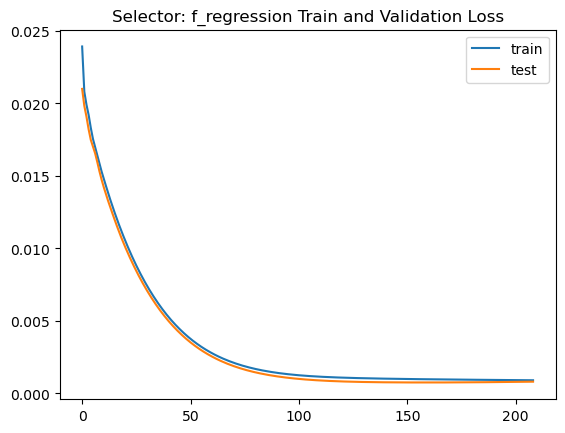

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


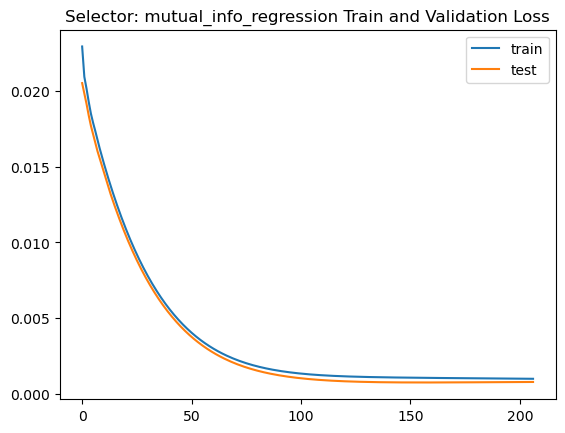

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


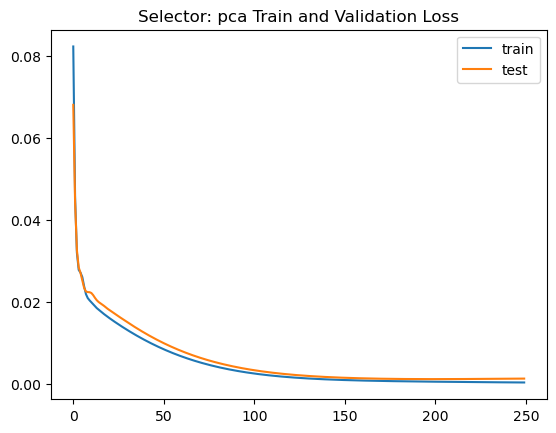

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


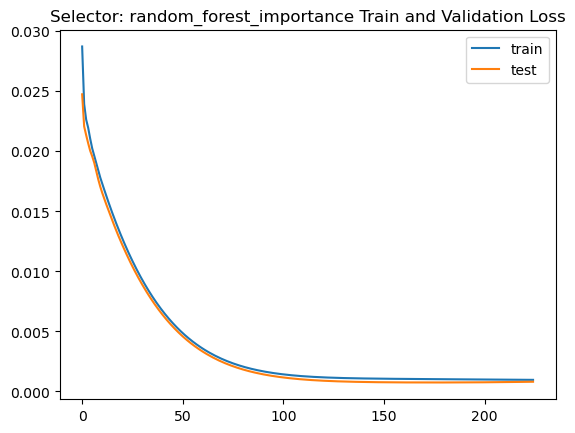

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [38]:
# Save weights during the training process to further access the weights
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import l2

tf.random.set_seed(seed)

feature_selector = ['f_regression', 'mutual_info_regression', 'pca', 'random_forest_importance']
# feature_selector = ['f_regression']

LSTM_train_error = {}
LSTM_test_error = {}
LSTM_models = {}

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (validation loss in this case)
    patience=50,         # Number of epochs with no improvement to wait
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)

for selector in feature_selector:
    X_train_LSTM, X_test_LSTM, Y_train_LSTM, Y_test_LSTM = generate_LSTM_data(selector)
    # Lstm Network
    def create_LSTMmodel(neurons=12, learn_rate = 0.01, momentum=float(0.0)):
        # Define the Training, Testing Data

        # create model
        model = Sequential()
        model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
        #More number of cells can be added if needed
        #Add regularizer
        model.add(Dense(1, kernel_regularizer=l2(0.01)))
        optimizer = SGD(learning_rate=learn_rate, momentum=float(momentum))
        model.compile(loss='mse', optimizer='adam')
        return model
    
    LSTMModel = create_LSTMmodel(12, learn_rate = 0.01, momentum=0)
    LSTMModel_fit = LSTMModel.fit(
        X_train_LSTM, Y_train_LSTM,
        validation_data=(X_test_LSTM, Y_test_LSTM),
        epochs=300,  # Maximum number of epochs
        batch_size=44,
        callbacks=[early_stopping],  # Include EarlyStopping in callbacks
        verbose=0,
        shuffle=False
    )

    # Store the model
    LSTM_models[selector] = LSTMModel

    #Visual plot to check if the error is reducing
    pyplot.plot(LSTMModel_fit.history['loss'], label='train')
    pyplot.plot(LSTMModel_fit.history['val_loss'], label='test')
    pyplot.title(f"Selector: {selector} Train and Validation Loss")
    pyplot.legend()
    pyplot.show()

    # Training and Testing Error
    error_Training_LSTM = mean_squared_error(Y_train_LSTM, LSTMModel.predict(X_train_LSTM))
    predicted = LSTMModel.predict(X_test_LSTM)
    error_Test_LSTM = mean_squared_error(Y_test,predicted)

    LSTM_train_error[selector] = error_Training_LSTM
    LSTM_test_error[selector] = error_Test_LSTM

In [39]:
# Find the best model
min = np.inf
best_selector = ""
for selector, test_error in LSTM_test_error.items():
    if test_error<min:
        min = test_error
        best_selector = selector

print(f"Best LSTM Model:\nSelector: {best_selector}\nTrain Error: {LSTM_train_error[best_selector]}\nTest Error: {LSTM_test_error[best_selector]}")

Best LSTM Model:
Selector: mutual_info_regression
Train Error: 0.0010033489083806039
Test Error: 0.0006990970866481242


## Comparison between Machine Learning Model, Time Series, LSTM

In [40]:
lowest_test_results['pca']

('RFR', np.float64(0.00017176739182642764), np.float64(0.0006162323521441384))

In [41]:
# Find the best model for each method

# Machine Learning models (PCA ABR); ARIMA (f_regression); LSTM (mutual_info_regression)
models = ['Machine Learning (ABR-PCA)', 'ARIMA (random_forest_importance)', 'LSTM (mutual_info_regression)']
train_errors = [lowest_test_results['pca'][1], error_Training_ARIMA['random_forest_importance'], LSTM_train_error['mutual_info_regression'] ]  # Replace with your values
test_errors = [lowest_test_results['pca'][2], error_Test_ARIMA['random_forest_importance'], LSTM_test_error['mutual_info_regression']]   # Replace with your values

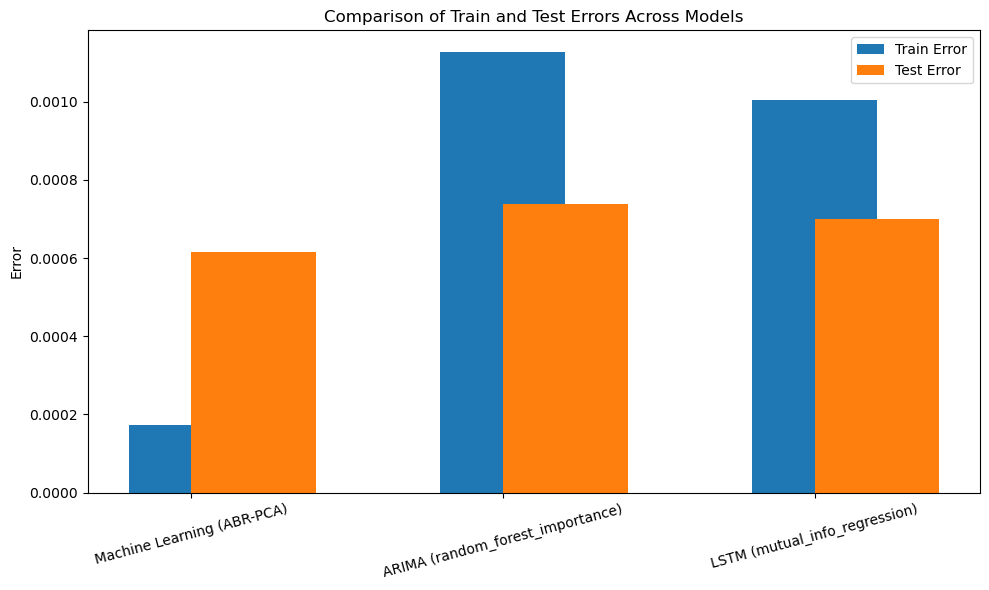

In [42]:
x = range(len(models))

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(x, train_errors, width=0.4, label='Train Error', align='center')
plt.bar(x, test_errors, width=0.4, label='Test Error', align='edge')

# Add labels, title, and legend
plt.xticks(x, models, rotation=15)
plt.ylabel('Error')
plt.title('Comparison of Train and Test Errors Across Models')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [43]:
min_index = np.argmin(np.array(test_errors))
print(f"Best Results: {models[min_index]} - Validation Error: {test_errors[min_index]}")

Best Results: Machine Learning (ABR-PCA) - Validation Error: 0.0006162323521441384


Looking at the chart above, we find that all three models perform really well. By looking at the validation error, we can see that when using **PCA** as feature selector and using **ABR** as our machine leraning model lead to the lowest validation error.

In the next section, we will be tuning this model to find the optimal hyperparameter

<a id='5'></a>
# 6. Model Tuning and Grid Search

As shown in the chart above, we will be using GridSearch to search through the parameter space of **PCA** and **ABR**. This will allow us to find the optimal paramters respectively

In [44]:
X_train, X_test, Y_train, Y_test = train_test_split('pca')

# Use grid search to search on ABR using PCA feature selector
# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the data
    ('pca', PCA()),                # PCA for dimensionality reduction
    ('abr', AdaBoostRegressor(random_state=42))  # AdaBoost Regressor
])

# Define the parameter grid for AdaBoost Regressor
param_grid = {
    'pca__n_components': [0.85, 0.9, 0.95],  # Variance explained thresholds
    'abr__n_estimators': [50, 100, 200],     # Number of weak learners (trees)
    'abr__learning_rate': [0.01, 0.1, 1.0],  # Learning rate
    'abr__loss': ['linear', 'square', 'exponential']  # Loss functions
}

# Create GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring='neg_mean_squared_error',  # Use MSE as the scoring metric
    cv=5,                              # 5-fold cross-validation
    n_jobs=-1,                         # Use all CPUs
    verbose=2
)

# Fit the grid search
grid_search.fit(X_train, Y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
print("Best Parameters:", best_params)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'abr__learning_rate': 0.01, 'abr__loss': 'linear', 'abr__n_estimators': 200, 'pca__n_components': 0.85}


<a id='6'></a>
# 7. Finalise the Model

<a id='6.1'></a>
## 7.1. Results on the Test Dataset

In [45]:
X_train, X_test, Y_train, Y_test = train_test_split('pca')

best_model = grid_search.best_estimator_

# Evaluate the training set
y_train_pred = best_model.predict(X_train)
train_mse = mean_squared_error(Y_train, y_train_pred)
print("Train MSE: ", train_mse)

# Evaluate on the test set
Y_pred = best_model.predict(X_test)
test_mse = mean_squared_error(Y_test, Y_pred)

# Print results
print("Test MSE:", test_mse)

Train MSE:  0.0007672865319608793
Test MSE: 0.0006473180544016745


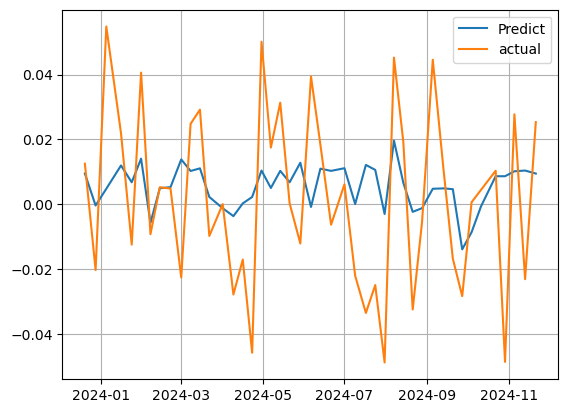

In [46]:
prediction = best_model.predict(X_test)
actual = Y_test

x_range = Y_test.index

plt.plot(x_range, prediction, label="Predict")
plt.plot(x_range, actual, label = "actual")
plt.legend()
plt.grid(True)
plt.show()


## 7.3. Feature Importance

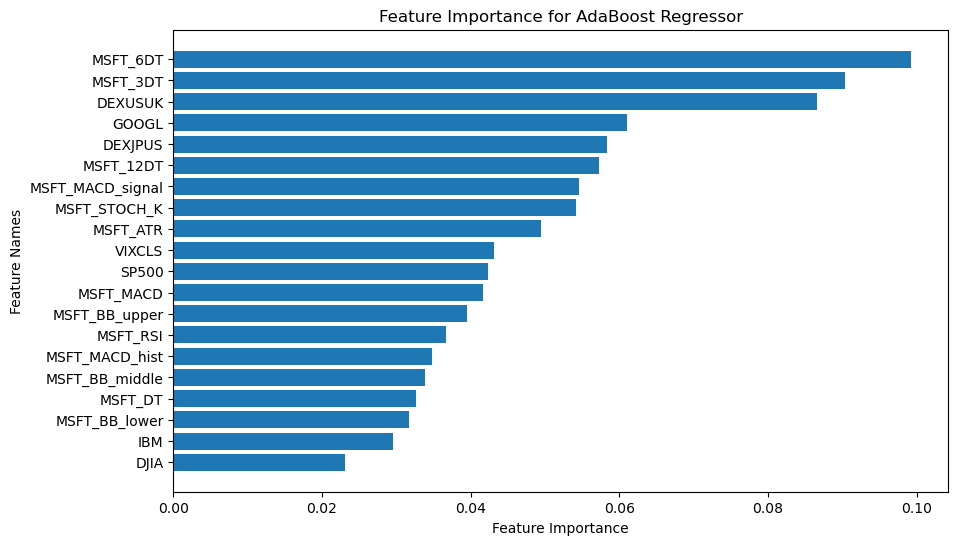

In [60]:
feature_importances = best_model[2].feature_importances_

# Ensure you have the corresponding feature names (from your dataset)
feature_names = X_train.columns  # Replace with the feature names used in training

# Sort the feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_feature_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Feature Names")
plt.title("Feature Importance for AdaBoost Regressor")
plt.gca().invert_yaxis()  # Invert y-axis to show highest importance at the top
plt.show()

## 7.2. Evaluate with Financial Metrics

In [47]:

# Financial metrics functions
def calculate_profit_factor(returns):
    profits = np.where((returns >= 0), returns, 0)
    losses = np.where((returns < 0), returns, 0)
    p_ratio = np.sum(profits)/np.sum(np.abs(losses))
    return p_ratio

def calculate_cagr(returns):
    cum_return = np.cumprod(returns+1)-1

    # Calculate CAGR
    cagr = (1 + cum_return[-1]) ** (52 / (len(cum_return))) - 1

    return cagr

def calculate_sharpe_ratio(returns):
    return (52 ** (1.0/2.0)) * np.mean(returns) / np.std(returns)

# Evaluate the best model with financial metrics
def evaluate_trading_metrics(predictions, actual_returns):
    returns = actual_returns * predictions #This is log return
    returns = np.exp(returns)-1 #This is percentage return
    profit_factor = calculate_profit_factor(returns)
    cagr = calculate_cagr(returns)
    sharpe_ratio = calculate_sharpe_ratio(returns)
    return profit_factor, cagr, sharpe_ratio

# Example workflow (replace with actual data and models)
pred = best_model.predict(X_test)
actual_returns = Y_test.values
predictions = np.where(pred>0, 1, -1)

# Calculate metrics
profit_factor, cagr, sharpe_ratio = evaluate_trading_metrics(predictions, actual_returns)
print(f"Profit Factor: {profit_factor:.2f}, CAGR: {cagr:.2%}, Sharpe Ratio: {sharpe_ratio:.2f}")

Profit Factor: 2.05, CAGR: 47.01%, Sharpe Ratio: 2.15


## 7.3. White Reality Check and Monte Carlo

In [48]:
def detrendPrice(series):
    # fit linear model
    length = len(series)
    x = np.arange(length)
    y = np.array(series.values)
    x_const = sm.add_constant(x) #need to add intercept constant
    model = sm.OLS(y,x_const)
    result = model.fit()
    
    df = pd.DataFrame(result.params*x_const)
    y_hat = df[0] + df[1]
    #the residuals are the detrended prices
    resid = y-y_hat
    #add minimum necessary to residuals to avoid negative detrended prices
    resid = resid + abs(resid.min() + 1/10*resid.min())
    return resid

def bootstrap(ser):
    ser.dropna(inplace=True)
    # ser = np.log(ser+1)
    arr = np.array(ser.values)
    alpha = .05*100 #significance alpha
    reps = 5000 #how many bootstrapings, 50000 limit if you have 8GB RAM

    percentile = 100-alpha
    ave = np.average(arr) #arithmetic mean

    print("average return %f" %ave)

    centered_arr = arr-ave
    n = len(centered_arr)
    #constructs 50000 alternative return histories and calculates their theoretical averages
    xb = np.random.choice(centered_arr, (n, reps), replace=True)
    mb = xb.mean(axis=0) #arithmetic mean

    #sorts the 50000 averages
    mb.sort()
    #calculates the 95% conficence interval (two tails) threshold for the theoretical averages
    print(np.percentile(mb, [2.5, 97.5]))
    threshold = np.percentile(mb, [percentile])[0]


    if ave > threshold:
        print("Reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)")
    else:
        print("Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)")

    #count will be the items i that are smaller than ave
    count_vals = 0
    for i in mb:
        count_vals += 1
        if i > ave:
            break

    #p is based on the count that are larger than ave so 1-count is needed:
    p = 1-count_vals/len(mb)

    print("p_value:")
    print(p)

    #histogram
    sr = pd.Series(mb)
    desc = sr.describe()
    count = desc[0]
    std = desc[2]
    minim = desc[3]
    maxim = desc[7]
    R = maxim-minim
    n = count
    s = std
    bins = int(round(R*(n**(1/3))/(3.49*std),0))
    fig = sr.hist(bins=bins)
    plt.axvline(x = ave, color = 'b', label = 'axvline - full height')
   # plt.show()

average return 0.034005
[-0.01458913  0.01460803]
Reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)
p_value:
0.0


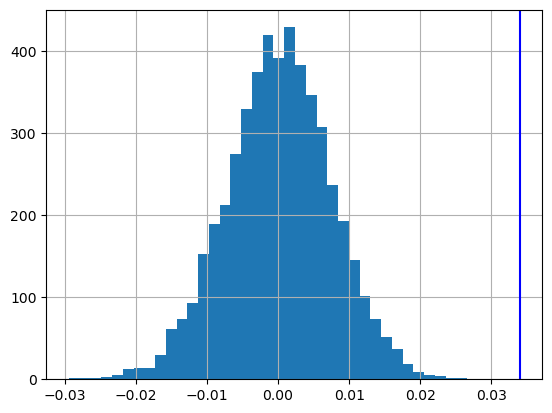

In [49]:
# White Reality Check

predict = best_model.predict(X_test)

positions2 = np.where(predict > 0, 1, -1)

detrended_retFut1 = detrendPrice(Y_test)

# Convert positions2 into a Series with the same index as detrended_retFut1
positions_series = pd.Series(data=positions2, index=detrended_retFut1.index)

# Broadcast positions2 to all columns of detrended_retFut1 (row-wise multiplication)
detrended_syst_rets = detrended_retFut1.mul(positions_series, axis=0)

bootstrap(detrended_syst_rets)


In [50]:
# Monte Carlo Permutation

num_permutations = 1000
permutation_means = np.zeros(num_permutations)
ori_perdictions = best_model.predict(X_test)
position = np.where(ori_perdictions>0, 1,-1)
ori_return = position*Y_test
ori_mean_return = ori_return.mean()

count = 0
for i in range(num_permutations):
    permute = np.random.permutation(X_test)
    predictions = best_model.predict(permute)
    positions = np.where(predictions > 0, 1, -1)
    permutation_return = positions*Y_test
    permutation_means[i] = permutation_return.mean()
    if permutation_means[i] > ori_mean_return:
        count+=1

p_val = (count+1)/(num_permutations+1)
print(f"Monte Carlo Permutation p-value: {p_val}")

Monte Carlo Permutation p-value: 0.03796203796203796


## 7.4.Plot the Training and Testing Curve

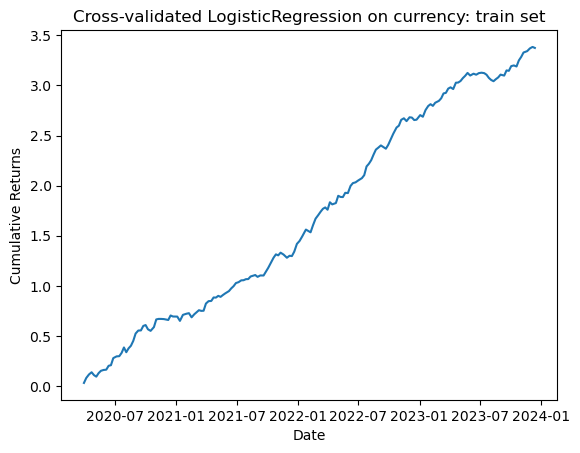

In [51]:
# Train set
# Make "predictions" on training set (in-sample)
positions = np.where(best_model.predict(X_train)> 0,1,-1 ) #POSITIONS

#dailyRet = pd.Series(positions).shift(1).fillna(0).values * x_train.ret1 #for trading at the close
syst_return = pd.Series(positions).fillna(0).values * Y_train #for trading right after the open

syst_return = syst_return.fillna(0)

cumret = np.cumsum(syst_return)


plt.figure(1)
plt.plot(cumret.index, cumret)
plt.title('Cross-validated LogisticRegression on currency: train set')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')

plt.show()

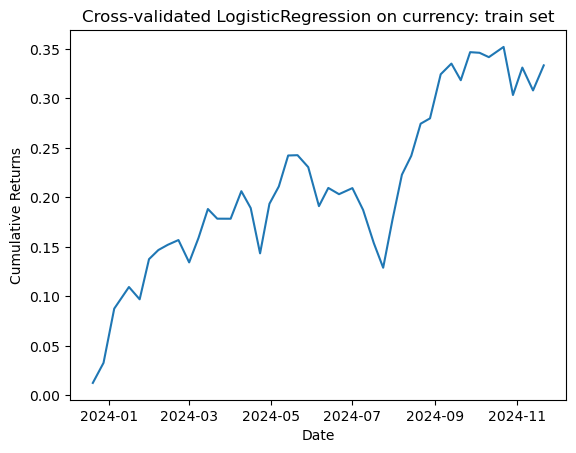

In [52]:
# Train set
# Make "predictions" on training set (in-sample)
#positions = np.where(best_model.predict(x_train)> 0,1,-1 )
positions = np.where(best_model.predict(X_test)> 0,1,-1 ) #POSITIONS

#dailyRet = pd.Series(positions).shift(1).fillna(0).values * x_train.ret1 #for trading at the close
syst_return = pd.Series(positions).fillna(0).values * Y_test #for trading right after the open

syst_return = syst_return.fillna(0)

cumret = np.cumsum(syst_return)

plt.figure(1)
plt.plot(cumret.index, cumret)
plt.title('Cross-validated LogisticRegression on currency: train set')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')

plt.show()

<a id='6.2'></a>
## 7.2. Save Model for Later Use

In [53]:
# Import the required methods from pickle
from pickle import dump, load

In [54]:
# Specify the filename
filename = 'best_model.sav'

# Save the model to disk
dump(best_model, open(filename, 'wb'))
print(f"Model saved as {filename}")


Model saved as best_model.sav


In [55]:
# Load the saved model from disk
best_model = load(open('best_model.sav', 'rb'))

# Verify the loaded model
print(f"Model loaded: {best_model}")


Model loaded: Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.85)),
                ('abr',
                 AdaBoostRegressor(learning_rate=0.01, n_estimators=200,
                                   random_state=42))])


### Summary

We can conclude that with the introduction of technical indicators does indeed lead to slightly better result compare with the seed code. The process of finding the most fit technical indicator is a time consuming process. With the usage of different feature selection method, we are able to pick the top 5 most informative features with respect to the target.

In this case study, **PCA**, **Mutual info Regression**, **f_regression**, and **random forest importance** method is used to select the top 5 technical indicators that are going to be applied to both machine learning and deep learning model.

Lastly, by implementing the financial metrics (**Sharpe Ratio**, **Proft Factor**, **CAGR**) gives us an insight of how our trading system perform as a whole. Also, by testing the trading system with **White Reality Check** and **Monte Carlo Permutation** ensures us that the trading system doesn't happen by chance, instead it does learn the pattern from the dataset and does have the confidence of generating a promising prediction